In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import f1_score, recall_score, accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.inspection import permutation_importance

np.random.seed(113)

%config InlineBackend.figure_format = 'retina'

#### _This notebook was used for training and evaluating classifiers which were later used for Oscar predictions:_<br>
1. PART 1: predicting Oscar contenders (any category)
2. PART 2: predicting Oscar winners (any category)
3. PART 3: predicting Best Picture conenders
4. PART 4: predicting Best Picture winners

***
### Setup

#### Display preferences

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
colors = ['#dbbd5a', '#d2ad32', '#ae8e25']  #shades of "gold", from lightest to darkest (with help from icolorpalette.com)
cmap_name_ = 'golds'
golds = LinearSegmentedColormap.from_list(cmap_name_, colors, N=100)

colors = ['#fcfaf4', '#e8d596', '#dec267', '#d4af38', '#d4af38']  #shades of "gold", from lightest to darkest (with help from icolorpalette.com)
cmap_n = 'golds_cm'
golds_cm = LinearSegmentedColormap.from_list(cmap_n, colors, N=100)

colors_ext = ['#f5edd3', '#ecddab', '#e4cd82', '#dbbd5a', '#d2ad32', '#ae8e25', '#866d1c', '#5e4c14', '#352b0b']  #shades of "gold", from lightest to darkest (with help from icolorpalette.com)
name = 'golds_ext'
golds_ext = LinearSegmentedColormap.from_list(name, colors_ext, N=100)

#### Reading in data

In [4]:
titles = pd.read_csv('../data/title_basics_1990_2020.csv', index_col = 'tconst')
movies = pd.read_csv('../data/movies_1990_2020_with_oscars_complete.csv', index_col= 'tconst', low_memory=False)
movies_2020 = movies[movies['startYear']==2020] # the 2020 ceremony took place on 2/9/2020, so all movies made that year can be considered potential contenders for 2021 (release dates are susceptible to nans and thus less reliable than startYear)
movies = movies[movies['startYear']<2020]

In [5]:
X_vars_all = ['runtimeMinutes', 'Action', 'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News',
       'Reality-TV', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 
       'Warner Bros.', 'Universal Pictures', 'Columbia Pictures',
       'Paramount Pictures', 'Dreamworks Pictures', 'Walt Disney Pictures',
       'Miramax', 'Twentieth Century Fox', 'New Line Cinema', 'Focus Features',
       'Fox Searchlight Pictures', 'Touchstone Pictures',
       'Walt Disney Animation Studios', 'BBC Films', 'TriStar Pictures',
       'New Regency Productions', 'Fox 2000 Pictures', 'The Weinstein Company',
       'Annapurna Pictures', 'Castle Rock Entertainment',
        'oscars_post_release', 'US_open_WE', 'prev_Oscars', 'rel_USA', 'prev_Oscar_wins_nm', 'prev_Oscar_noms_nm', 'GG',
       'rel__aug', 'rel__dec', 'rel__feb', 'rel__jan', 'rel__jul', 'rel__jun',
       'rel__mar', 'rel__may', 'rel__nov', 'rel__oct', 'rel__sep',
             'budget_USD']

#### Baseline model for binary classifications using only target variable as input

In [6]:
class BaselineModel:
  def __init__(self, dep_var):
    self.y = dep_var

  def predict(self):
    return [round(self.y.mean(),)]*len(self.y)

  def score(self):
    return accuracy_score(self.y, [round(self.y.mean(),)]*len(self.y))

#### A function to plot a regular CM and one that's corrected for the duplicates introduced through bootstrapping

In [7]:
def plot_confusion_matrices(est, X_test, y_test, cmap, labels, ver):
    
    fig, axes = plt.subplots(1,2, figsize=(17,5))
    plt.rcParams['text.color'] = '#dfc56e'
    plot_confusion_matrix(estimator = est, X = X_test, y_true = y_test, ax=axes[0], cmap=cmap, display_labels = labels, values_format = 'd')
    axes[0].set_title(f"Confusion matrix with duplicates from bootstrapping",fontsize=20, color='#dfc56e', pad=20)
    axes[0].set_xlabel("Predicted label", fontsize=11, color='#dfc56e')
    axes[0].set_ylabel('True label', fontsize=11, color='#dfc56e')
    axes[0].set_xticklabels(labels, fontsize=11, color='#dfc56e')
    axes[0].set_yticklabels(labels, fontsize=11, color='#dfc56e');

    Z_test_df = pd.DataFrame(X_test)
    Z_test_df['y_test'] = np.array(y_test)
    Z_test_df = Z_test_df.drop_duplicates()
    y_test_nd = Z_test_df['y_test']
    Z_test_df.drop(columns = ['y_test'], inplace = True)
    Z_test_nd = Z_test_df
    plot_confusion_matrix(estimator = est, X = Z_test_nd, y_true = y_test_nd, ax=axes[1], cmap = cmap, display_labels = labels, values_format = 'd')
    axes[1].set_title(f"Confusion matrix without duplicates from bootstrapping",fontsize=20, color='#dfc56e', pad=20)
    axes[1].set_xlabel("Predicted label", fontsize=11, color='#dfc56e')
    axes[1].set_ylabel('True label', fontsize=11, color='#dfc56e');
    axes[1].set_xticklabels(labels, fontsize=11, color='#dfc56e')
    axes[1].set_yticklabels(labels, fontsize=11, color='#dfc56e');
    
    plt.tight_layout();
    
    plt.savefig('../visualizations/conf_mtrcs_'+ver+'.png',facecolor=fig.get_facecolor(), edgecolor='none')

***
## PART 1: Predicting which movies are likely to become Oscar **contenders**

### 1.1. Baseline model

In [8]:
movies['Oscars'].value_counts(normalize= False)

0    174496
1      1199
Name: Oscars, dtype: int64

In [9]:
y = movies['Oscars']
bm = BaselineModel(y)
print(f"The naive baseline model has accuracy of {round(bm.score(),4)} and recall of {round(recall_score(y, bm.predict()),4)}.")

The naive baseline model has accuracy of 0.9932 and recall of 0.0.


### 1.2. Bootstrapping Oscars data to correct for class imbalance

In [10]:
movies_btstrp = pd.concat([movies, movies[movies['Oscars']==1].sample(n = 100000, replace = True, random_state=113)], axis = 0) # randomly resampling additional 100,000 titles with Oscar nominations or wins

In [11]:
movies_btstrp['Oscars'].value_counts(normalize=False)

0    174496
1    101199
Name: Oscars, dtype: int64

### 1.3. Logistic regression on bootstrapped data

#### 1.3.1 Looping through all independent variables to pick pick n that are most predictive of the target in a logistic regression model:

In [12]:
# function that pick "best" n variables of from the set `X_vars_all` based on F1 score, balancing recall and precision

def find_best_n_vars(n):
    best_f1 = 0
    best_vars = None
    for i in range(1000):
        if i%100 == 0:
            print(f"On set {i+1}/1000")
        y = movies_btstrp['Oscars']
        X = movies_btstrp[np.random.choice(X_vars_all, size = n, replace = False)]
        train_X, test_X, train_y, test_y = train_test_split(X, y)
        stan = StandardScaler()
        train_X = stan.fit_transform(train_X)
        test_X = stan.transform(test_X)
        logr = LogisticRegression()
        logr.fit(train_X, train_y)
        if f1_score(test_y, logr.predict(test_X)) > best_f1:
            best_f1 = f1_score(test_y, logr.predict(test_X))
            best_vars = X.columns
            print(f"Best F1 so far is {round(best_f1,4)}...")
    print(f"Best F1 across all tested sets of variables is {round(best_f1, 4)}, for variables: {best_vars}.")        
    return best_f1, best_vars

In [13]:
find_best_n_vars(5)

On set 1/1000
Best F1 so far is 0.2164...
Best F1 so far is 0.5099...
Best F1 so far is 0.5376...
Best F1 so far is 0.7403...
Best F1 so far is 0.7476...
Best F1 so far is 0.7661...
Best F1 so far is 0.7742...
Best F1 so far is 0.8356...
On set 101/1000
On set 201/1000
Best F1 so far is 0.8459...
On set 301/1000
On set 401/1000
On set 501/1000
On set 601/1000
On set 701/1000
On set 801/1000
On set 901/1000
Best F1 across all tested sets of variables is 0.8459, for variables: Index(['Focus Features', 'GG', 'budget_USD', 'Drama', 'runtimeMinutes'], dtype='object').


(0.8458891183196785,
 Index(['Focus Features', 'GG', 'budget_USD', 'Drama', 'runtimeMinutes'], dtype='object'))

In [14]:
best_five_logr = ['Focus Features', 'GG', 'budget_USD', 'Drama', 'runtimeMinutes']

#### 1.3.2 Predicting Oscar contenders using all independent variabless in `X-vars_all`

In [15]:
X = movies_btstrp[X_vars_all]
y = movies_btstrp['Oscars']

X_train, X_test, y_train, y_test = train_test_split(X,y)

stan = StandardScaler()
X_train = stan.fit_transform(X_train)
X_test = stan.transform(X_test)

In [16]:
logr = LogisticRegression()
logr.fit(X_train, y_train)

print(f"Logistic regression using five most predictive variables has accuracy of {round(logr.score(X_train, y_train),4)} on train data and {round(logr.score(X_test, y_test),4)} on test data.")
print(f"The same model has a recall score of {round(recall_score(y_train, logr.predict(X_train)),4)} on train data and {round(recall_score(y_test, logr.predict(X_test)),4)} on test data.")

print(f"The model's accuracy calculated in 5-fold cross-validation is {round(cross_val_score(logr, X_test, y_test).mean(),4)}.")
print(f"The model's recall calculated in 5-fold cross-validation is {round(cross_val_score(logr, X_test, y_test, scoring='recall').mean(),4)}.")

Logistic regression using five most predictive variables has accuracy of 0.9161 on train data and 0.9167 on test data.
The same model has a recall score of 0.8299 on train data and 0.8306 on test data.
The model's accuracy calculated in 5-fold cross-validation is 0.9158.
The model's recall calculated in 5-fold cross-validation is 0.8283.


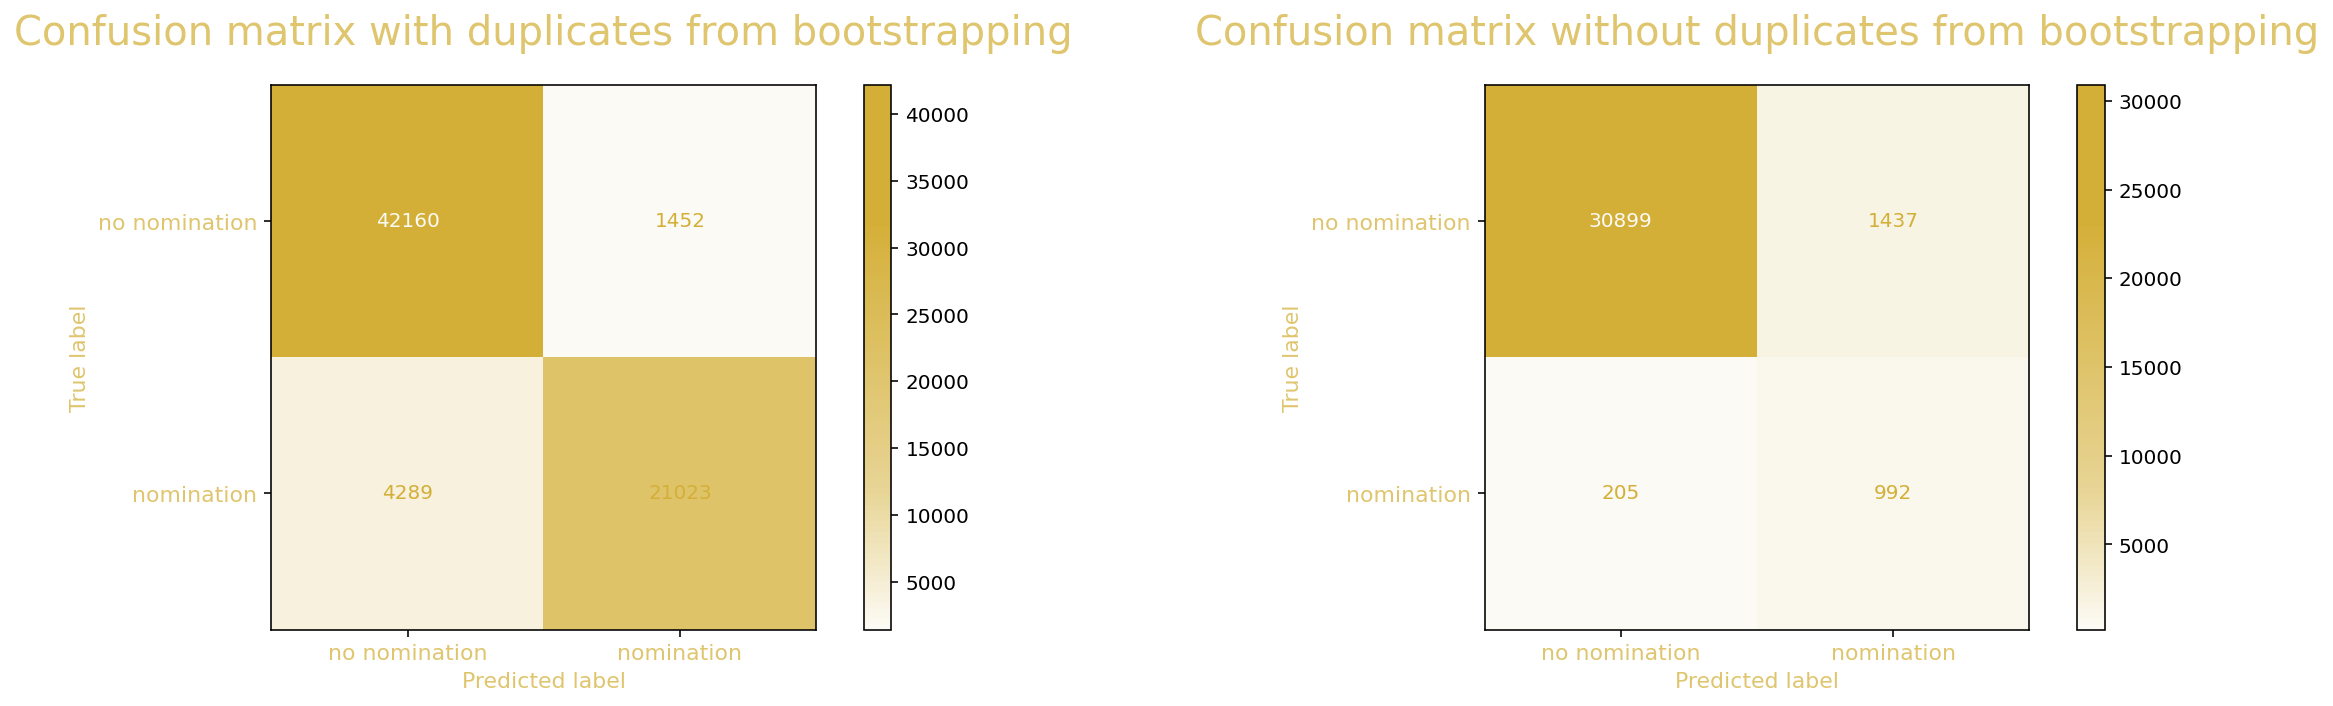

In [17]:
plot_confusion_matrices(logr, X_test, y_test, cmap = golds_cm, labels = ['no nomination', 'nomination'], ver = 'logr_f')

#### 1.3.3 Viewing and interpreting coefficients for most predictive variables

In [18]:
logr_coefs = pd.DataFrame(index = X_vars_all, data =np.array([logr.coef_[0], [np.e**logr.coef_[0][i] for i in range(len(X_vars_all))]]).T, columns=['coef','e^coef'] )
logr_coefs['prob_contender'] = logr_coefs['e^coef']/(1+logr_coefs['e^coef'])
logr_coefs.sort_values('coef', ascending = False)[:10]

,coef,e^coef,prob_contender
GG,2.139793,8.497682,0.894711
budget_USD,1.285276,3.615665,0.783347
prev_Oscars,0.926862,2.526570,0.716438
Documentary,0.831140,2.295934,0.696596
runtimeMinutes,0.655181,1.925490,0.658177
rel_USA,0.612394,1.844842,0.648487
Drama,0.598216,1.818872,0.645248
rel__jan,0.461441,1.586358,0.613356
Animation,0.396518,1.486640,0.597851
rel__feb,0.365409,1.441103,0.590349


Of the five most predictive variables,`GG`, which indicates whether the movie was nominated / won a Golden Globe, is the most importand determinant, followed by budget and history of Oscar movies among the cast and crew.

### 1.4. Random Forest Classification on bootstrapped data

#### 1.4.1 Predicting Oscar contenders using all independent variabless in X-vars_all

In [19]:
X = movies_btstrp[X_vars_all]
y = movies_btstrp['Oscars']

X_train, X_test, y_train, y_test = train_test_split(X,y)

stan = StandardScaler()
Z_train = stan.fit_transform(X_train)
Z_test = stan.transform(X_test)

In [20]:
rfc = RandomForestClassifier()
rfc.fit(Z_train, y_train)

print(f"The Random Forest Classifier has an accuracy of {round(rfc.score(Z_train, y_train),4)} on train data and {round(rfc.score(Z_test, y_test),4)} on test data.")
print(f"The same model has a recall score of {round(recall_score(y_train, rfc.predict(Z_train)),4)} on train data and {round(recall_score(y_test, rfc.predict(Z_test)),4)} on test data.")

print(f"The model's accuracy calculated in 5-fold cross-validation is {round(cross_val_score(rfc, Z_test, y_test).mean(),4)}.")
print(f"The model's recall calculated in 5-fold cross-validation is {round(cross_val_score(rfc, Z_test, y_test, scoring='recall').mean(),4)}.")

The Random Forest Classifier has an accuracy of 0.999 on train data and 0.9978 on test data.
The same model has a recall score of 0.9993 on train data and 0.9994 on test data.
The model's accuracy calculated in 5-fold cross-validation is 0.9951.
The model's recall calculated in 5-fold cross-validation is 0.9991.


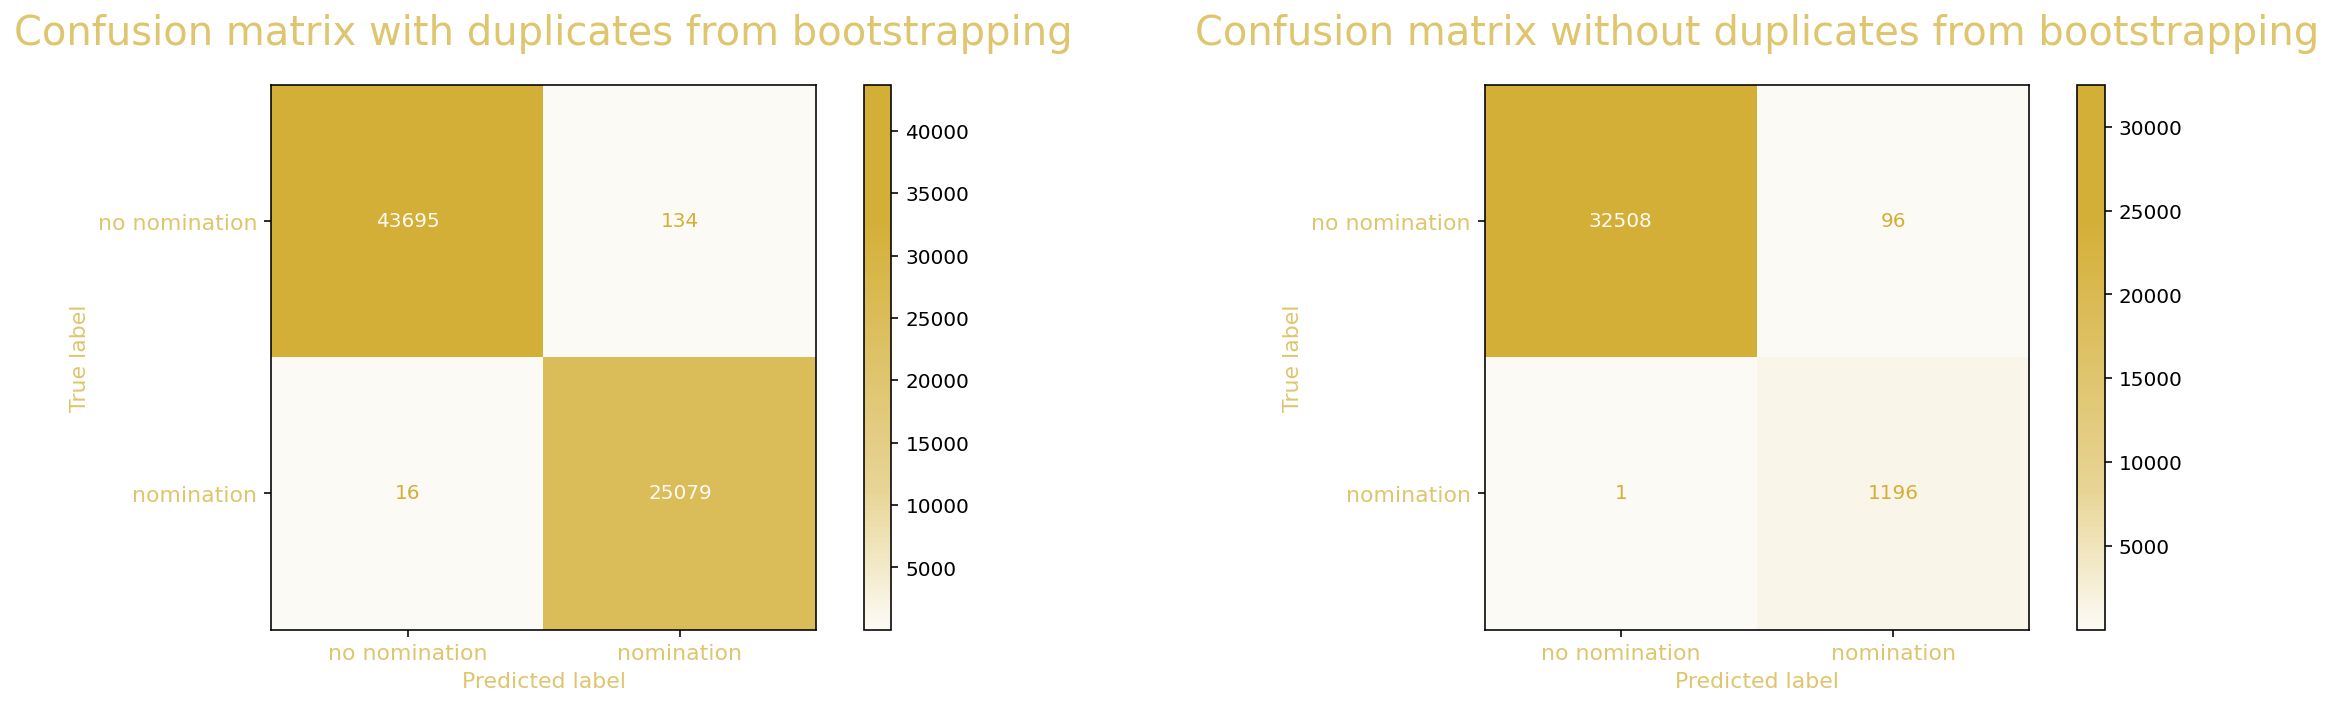

In [21]:
plot_confusion_matrices(rfc, Z_test, y_test, cmap = golds_cm, labels = ['no nomination', 'nomination'], ver = 'rfc_nom')

In [22]:
pickle.dump(rfc, open('../pickles/rfc_nom.p', 'wb'))

#### 1.4.2 Viewing and interpreting coefficients for most predictive variables

In [23]:
perm_imp = permutation_importance(rfc, Z_test, y_test)['importances_mean']

perm_imp_df = pd.DataFrame(perm_imp, index =X.columns, columns = ['permutation_imp'])

rfc_features = pd.DataFrame(index = X.columns, data = rfc.feature_importances_, columns=['feature_importance'])
rfc_features.sort_values(['feature_importance'], ascending = False, inplace = True)
rfc_features = rfc_features.merge(perm_imp_df, left_index = True, right_index = True)

rfc_features[:10]

,feature_importance,permutation_imp
US_open_WE,0.166537,0.099977
prev_Oscars,0.162697,0.089774
budget_USD,0.158408,0.105786
GG,0.113157,0.150125
runtimeMinutes,0.083341,0.086614
prev_Oscar_noms_nm,0.081951,0.046445
rel_USA,0.055248,0.064326
prev_Oscar_wins_nm,0.021897,0.003096
Drama,0.012782,0.029241
Documentary,0.010377,0.029723


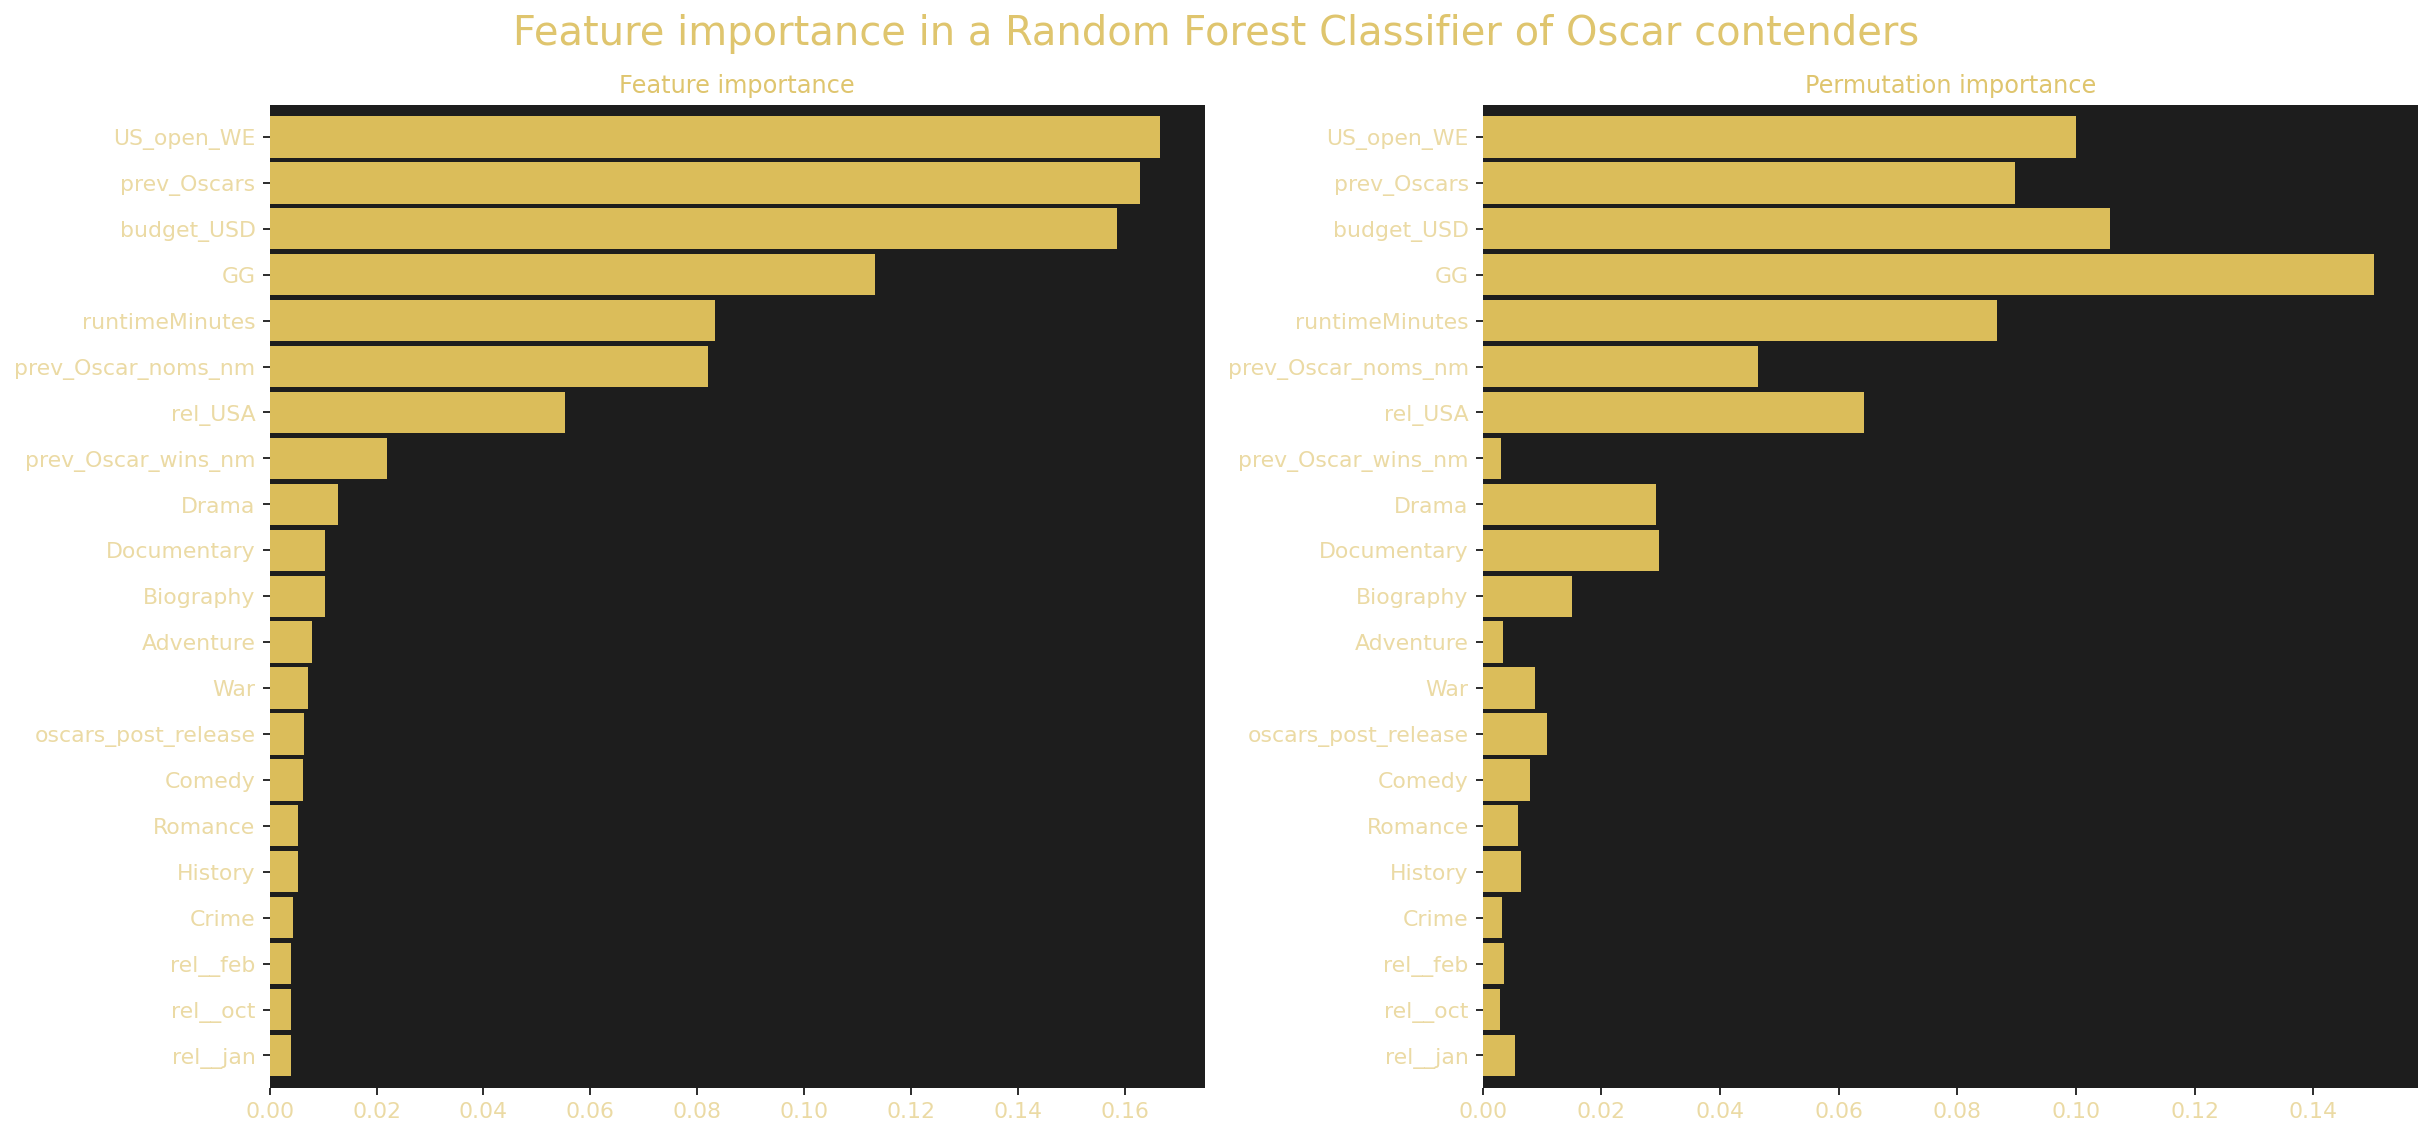

In [24]:
plt.figure(figsize=(17,8));
plt.rcParams['text.color'] = '#dfc56e'
plt.suptitle('Feature importance in a Random Forest Classifier of Oscar contenders\n',fontsize =20);
plt.subplot(1,2,1);
fig1 = rfc_features[20::-1]['feature_importance'].plot(kind= 'barh', cmap = golds, title = '\n\nFeature importance', width = 0.9)
fig1.patch.set_facecolor('#1d1d1d')
plt.yticks(fontsize=11, color='#ebdaa4')
plt.xticks(fontsize=11, color='#ebdaa4')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.subplot(1,2,2)
fig = rfc_features[20::-1]['permutation_imp'].plot(kind= 'barh', cmap = golds, title = 'Permutation importance', width = 0.9);
fig.patch.set_facecolor('#1d1d1d')
plt.yticks(fontsize=11, color='#ebdaa4')
plt.xticks(fontsize=11, color='#ebdaa4')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

plt.tight_layout();

plt.savefig('../visualizations/feat_imp_rfc_nom.png',facecolor=fig.get_facecolor(), edgecolor='none')

#### 1.4.3 Investigating false positives and false negatives

In [25]:
test_preds = pd.DataFrame(index = X_test.index, columns = ['RFC_win_nom', 'RFC_win_nom_proba'], 
                         data = np.array([rfc.predict(Z_test), [_[1] for _ in rfc.predict_proba(Z_test)]]).T)

true_win_nom = {tconst: twn for tconst, twn in zip(movies.index, movies['Oscars'])}
title = {tconst: title for tconst, title in zip(movies.index, movies['primaryTitle'])}

test_preds.sort_values('RFC_win_nom_proba', inplace= True, ascending=False)
test_preds['true_win_nom'] = test_preds.index.map(true_win_nom)
test_preds = test_preds.merge(titles[['primaryTitle', 'genres', 'runtimeMinutes']], how = 'left', left_index = True, right_index = True)

##### False positives

In [26]:
fp = test_preds[(test_preds['true_win_nom']==0) & (test_preds['RFC_win_nom']==1)].sort_values(['RFC_win_nom_proba'], ascending = False).head(10)
fp.drop_duplicates(inplace = True)
fp.sort_values(['RFC_win_nom_proba'], ascending = False).head(10)

,RFC_win_nom,RFC_win_nom_proba,true_win_nom,primaryTitle,genres,runtimeMinutes
tconst,,,,,,
tt1347087,1.0,1.000000,0,Renewal,Documentary,90
tt0388205,1.0,1.000000,0,Little Girl Blue,"Drama,Romance",82
tt0100024,1.0,1.000000,0,Life Is Sweet,"Comedy,Drama",103
tt2204371,1.0,1.000000,0,SOMM,Documentary,94
tt10643938,1.0,0.986494,0,Love for Sale 2,"Drama,Romance",92
tt5471184,1.0,0.986494,0,Love Affair,"Drama,Romance",92
tt3487902,1.0,0.984974,0,Marathonios mias Imitelous Anoixis: Grigoris L...,Documentary,114
tt0452971,1.0,0.984795,0,Dark Blue Almost Black,Drama,105
tt0099341,1.0,0.984795,0,Daddy Nostalgia,Drama,105


##### False negatives

In [27]:
fn = test_preds[(test_preds['true_win_nom']==1) & (test_preds['RFC_win_nom']==0)]
fn.drop_duplicates(inplace = True)
fn.sort_values(['RFC_win_nom_proba'], ascending = True).head(10)

<ipython-input-27-b7c00c195226>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fn.drop_duplicates(inplace = True)


,RFC_win_nom,RFC_win_nom_proba,true_win_nom,primaryTitle,genres,runtimeMinutes
tconst,,,,,,
tt0099598,0.0,0.189178,1,Forever Activists: Stories from the Veterans o...,Documentary,60


***
## PART 2: Predicting which movies are likely to become Oscar **winners**

### 2.1. Baseline model

In [28]:
movies['Oscar_winner'] = movies['o_wins'].apply(lambda x: np.where(x>0, 1, 0))
movies['Oscar_winner'].value_counts(normalize= False)

0    175462
1       233
Name: Oscar_winner, dtype: int64

In [29]:
y = movies['Oscar_winner']
bm = BaselineModel(y)
print(f"The naive baseline model has accuracy of {round(bm.score(),4)} and recall of {round(recall_score(y, bm.predict()),4)}.")

The naive baseline model has accuracy of 0.9987 and recall of 0.0.


### 2.2. Logistic regression on bootstrapped data

#### 2.2.1. Predicting Oscar winners using all independent variabless in `X-vars_all`

In [30]:
movies_btstrp['Oscar_winner'] = movies_btstrp['o_wins'].apply(lambda x: np.where(x>0, 1, 0))

X = movies_btstrp[X_vars_all]
y = movies_btstrp['Oscar_winner']

X_train, X_test, y_train, y_test = train_test_split(X,y)

stan = StandardScaler()
Z_train = stan.fit_transform(X_train)
Z_test = stan.transform(X_test)

In [31]:
logr_win = LogisticRegression()
logr_win.fit(X_train, y_train)

print(f"Logistic regression using five most predictive variables has accuracy of {round(logr_win.score(X_train, y_train),4)} on train data and {round(logr_win.score(X_test, y_test),4)} on test data.")
print(f"The same model has a recall score of {round(recall_score(y_train, logr_win.predict(X_train)),4)} on train data and {round(recall_score(y_test, logr_win.predict(X_test)),4)} on test data.")

print(f"The model's accuracy calculated in 5-fold cross-validation is {round(cross_val_score(logr_win, Z_test, y_test).mean(),4)}.")
print(f"The model's recall calculated in 5-fold cross-validation is {round(cross_val_score(logr_win, Z_test, y_test, scoring='recall').mean(),4)}.")

Logistic regression using five most predictive variables has accuracy of 0.8738 on train data and 0.8742 on test data.
The same model has a recall score of 0.0039 on train data and 0.0053 on test data.


/Users/martalew/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The model's accuracy calculated in 5-fold cross-validation is 0.933.


/Users/martalew/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The model's recall calculated in 5-fold cross-validation is 0.2828.


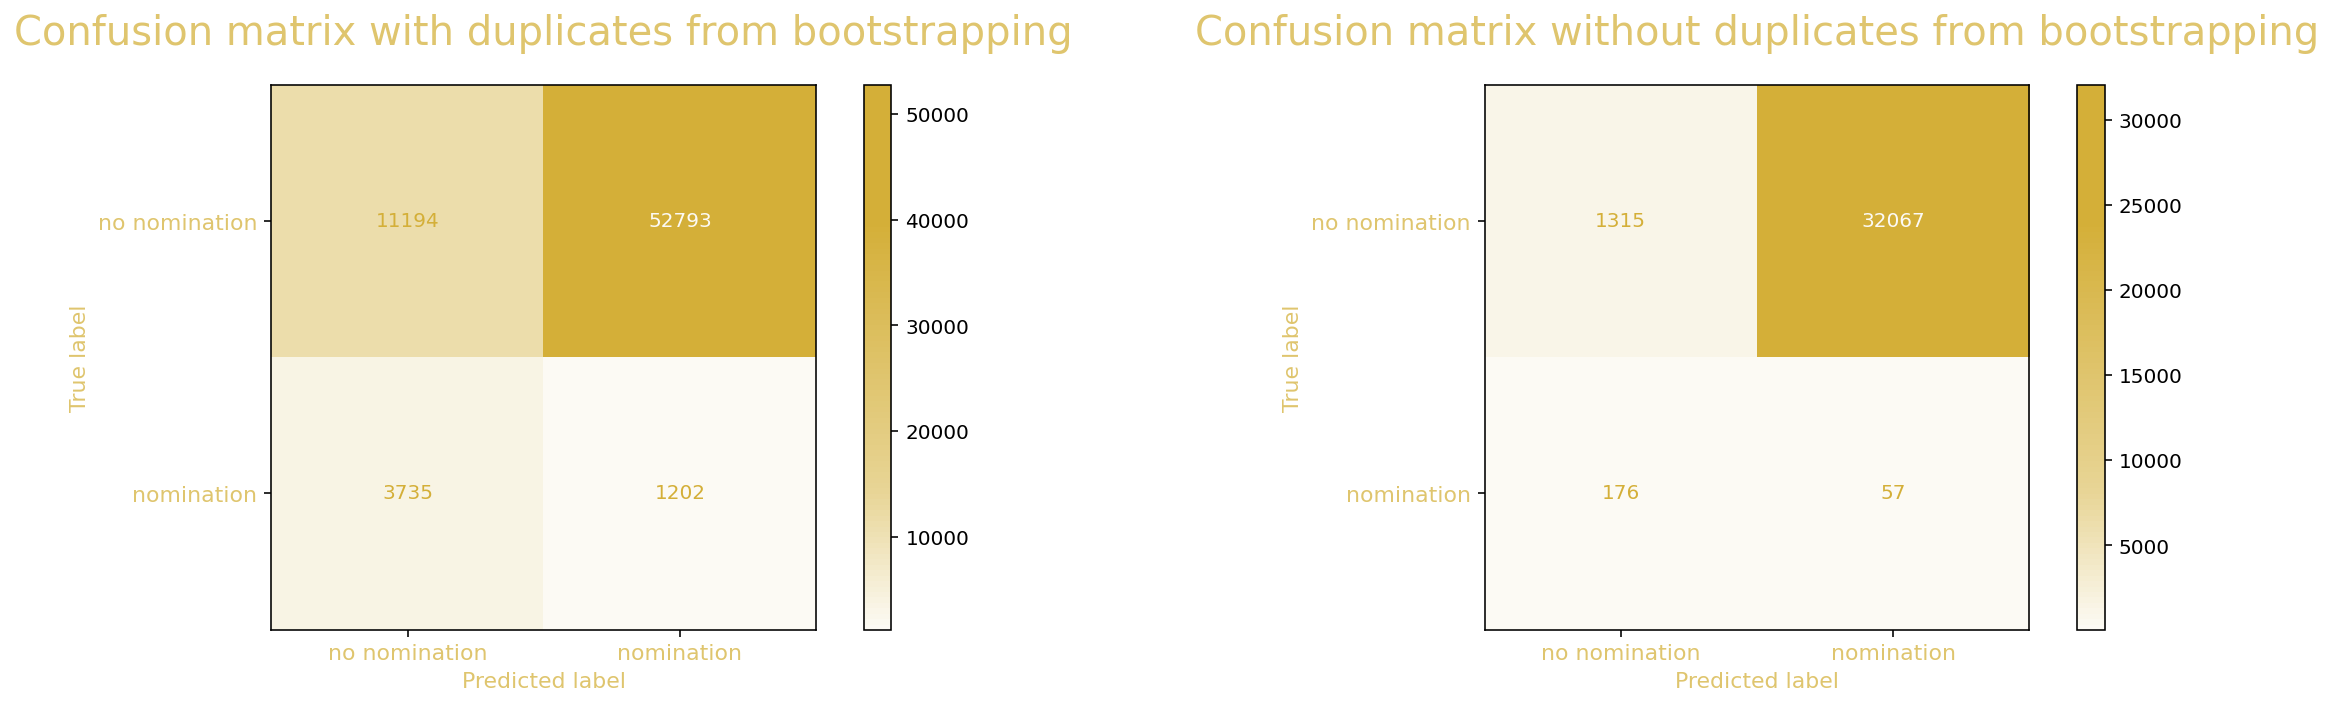

In [32]:
plot_confusion_matrices(logr_win, Z_test, y_test, cmap = golds_cm, labels = ['no nomination', 'nomination'], ver = 'logr_win')

### 2.3. Random Forest Classification on bootstrapped data

#### 2.3.1 Predicting Oscar winners using all independent variabless in X-vars_all

In [33]:
X = movies_btstrp[X_vars_all]
y = movies_btstrp['Oscar_winner']

X_train, X_test, y_train, y_test = train_test_split(X,y)

stan = StandardScaler()
Z_train = stan.fit_transform(X_train)
Z_test = stan.transform(X_test)

In [34]:
rfc_win = RandomForestClassifier()
rfc_win.fit(Z_train, y_train)

print(f"The Random Forest Classifier has an accuracy of {round(rfc_win.score(Z_train, y_train),4)} on train data and {round(rfc_win.score(Z_test, y_test),4)} on test data.")
print(f"The same model has a recall score of {round(recall_score(y_train, rfc_win.predict(Z_train)),4)} on train data and {round(recall_score(y_test, rfc_win.predict(Z_test)),4)} on test data.")

print(f"The model's accuracy calculated in 5-fold cross-validation is {round(cross_val_score(rfc_win, Z_test, y_test).mean(),4)}.")
print(f"The model's recall calculated in 5-fold cross-validation is {round(cross_val_score(rfc_win, Z_test, y_test, scoring='recall').mean(),4)}.")

The Random Forest Classifier has an accuracy of 0.9997 on train data and 0.9996 on test data.
The same model has a recall score of 1.0 on train data and 1.0 on test data.
The model's accuracy calculated in 5-fold cross-validation is 0.9996.
The model's recall calculated in 5-fold cross-validation is 0.9966.


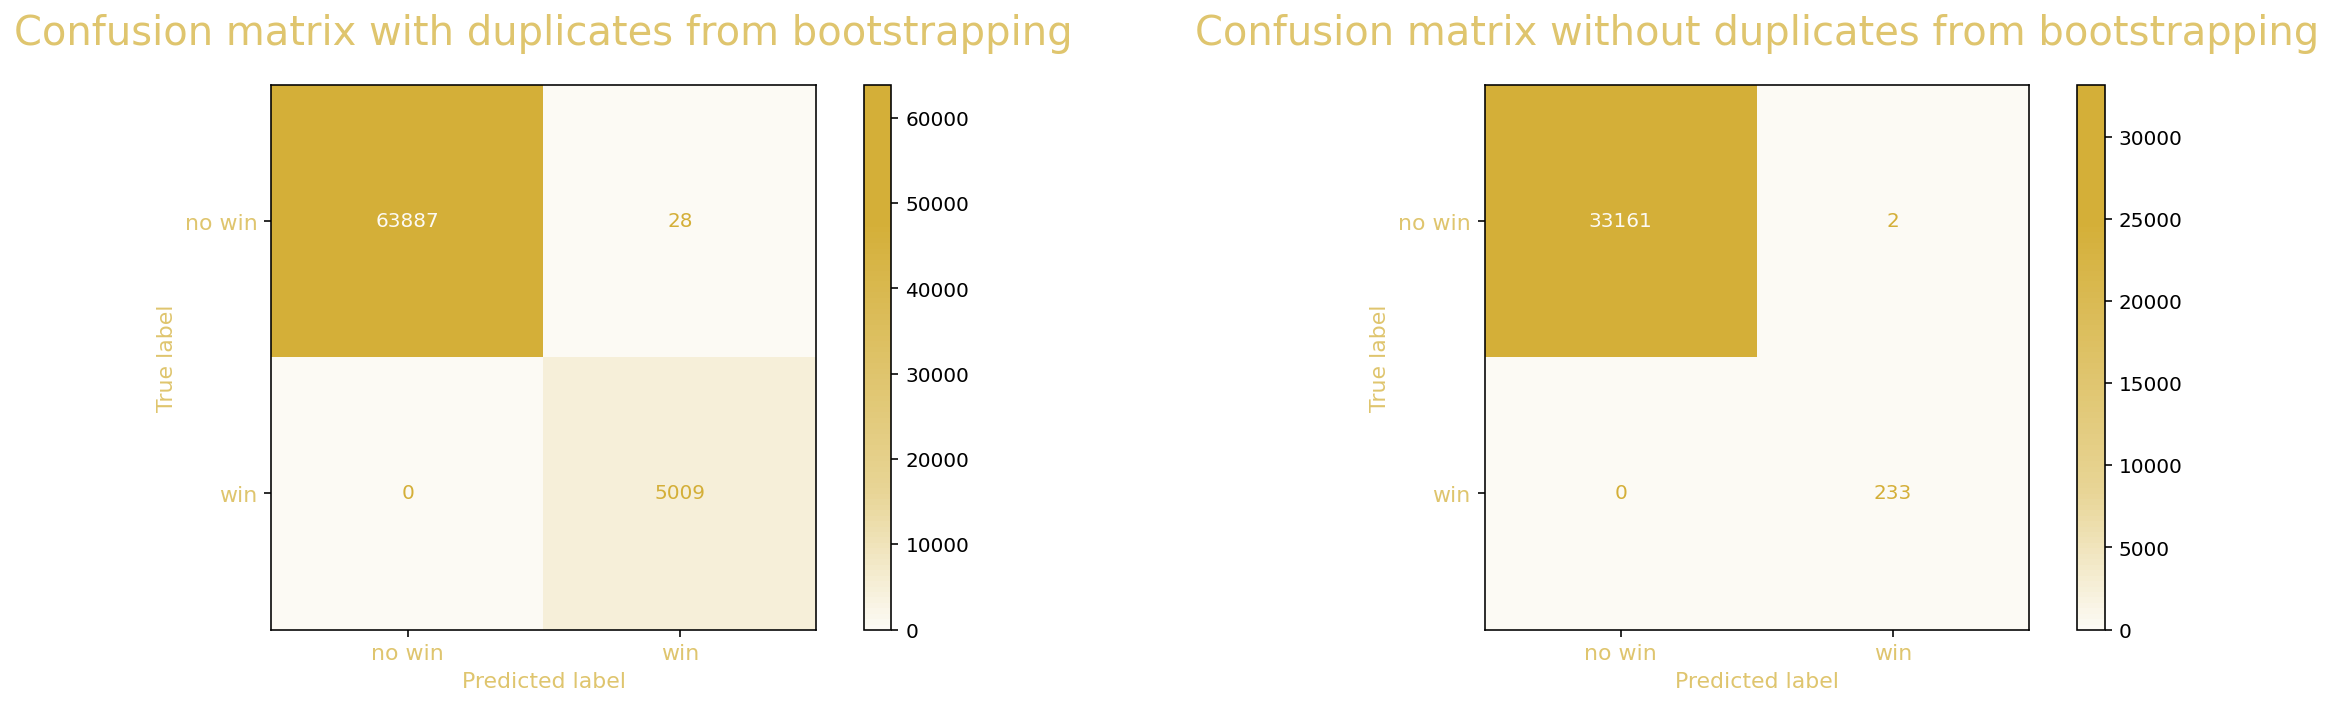

In [35]:
plot_confusion_matrices(rfc_win, Z_test, y_test, cmap = golds_cm, labels = ['no win', 'win'], ver = 'rfc_win')

In [36]:
pickle.dump(rfc_win, open('../pickles/rfc_win.p', 'wb'))

#### 2.4.2 Viewing and interpreting coefficients for most predictive variables

In [37]:
perm_imp = permutation_importance(rfc_win, Z_test, y_test)['importances_mean']

perm_imp_df = pd.DataFrame(perm_imp, index =X.columns, columns = ['permutation_imp'])

rfc_win_features = pd.DataFrame(index = X.columns, data = rfc_win.feature_importances_, columns=['feature_importance'])
rfc_win_features.sort_values(['feature_importance'], ascending = False, inplace = True)
rfc_win_features = rfc_win_features.merge(perm_imp_df, left_index = True, right_index = True)

rfc_win_features[:10]

,feature_importance,permutation_imp
US_open_WE,0.122663,0.012808
budget_USD,0.118398,0.019639
runtimeMinutes,0.107193,0.026682
GG,0.103720,0.052844
prev_Oscars,0.085992,0.001297
prev_Oscar_noms_nm,0.061332,0.000978
prev_Oscar_wins_nm,0.041731,0.000879
Biography,0.017279,0.002101
rel_USA,0.015739,0.004535
Drama,0.013922,0.002913


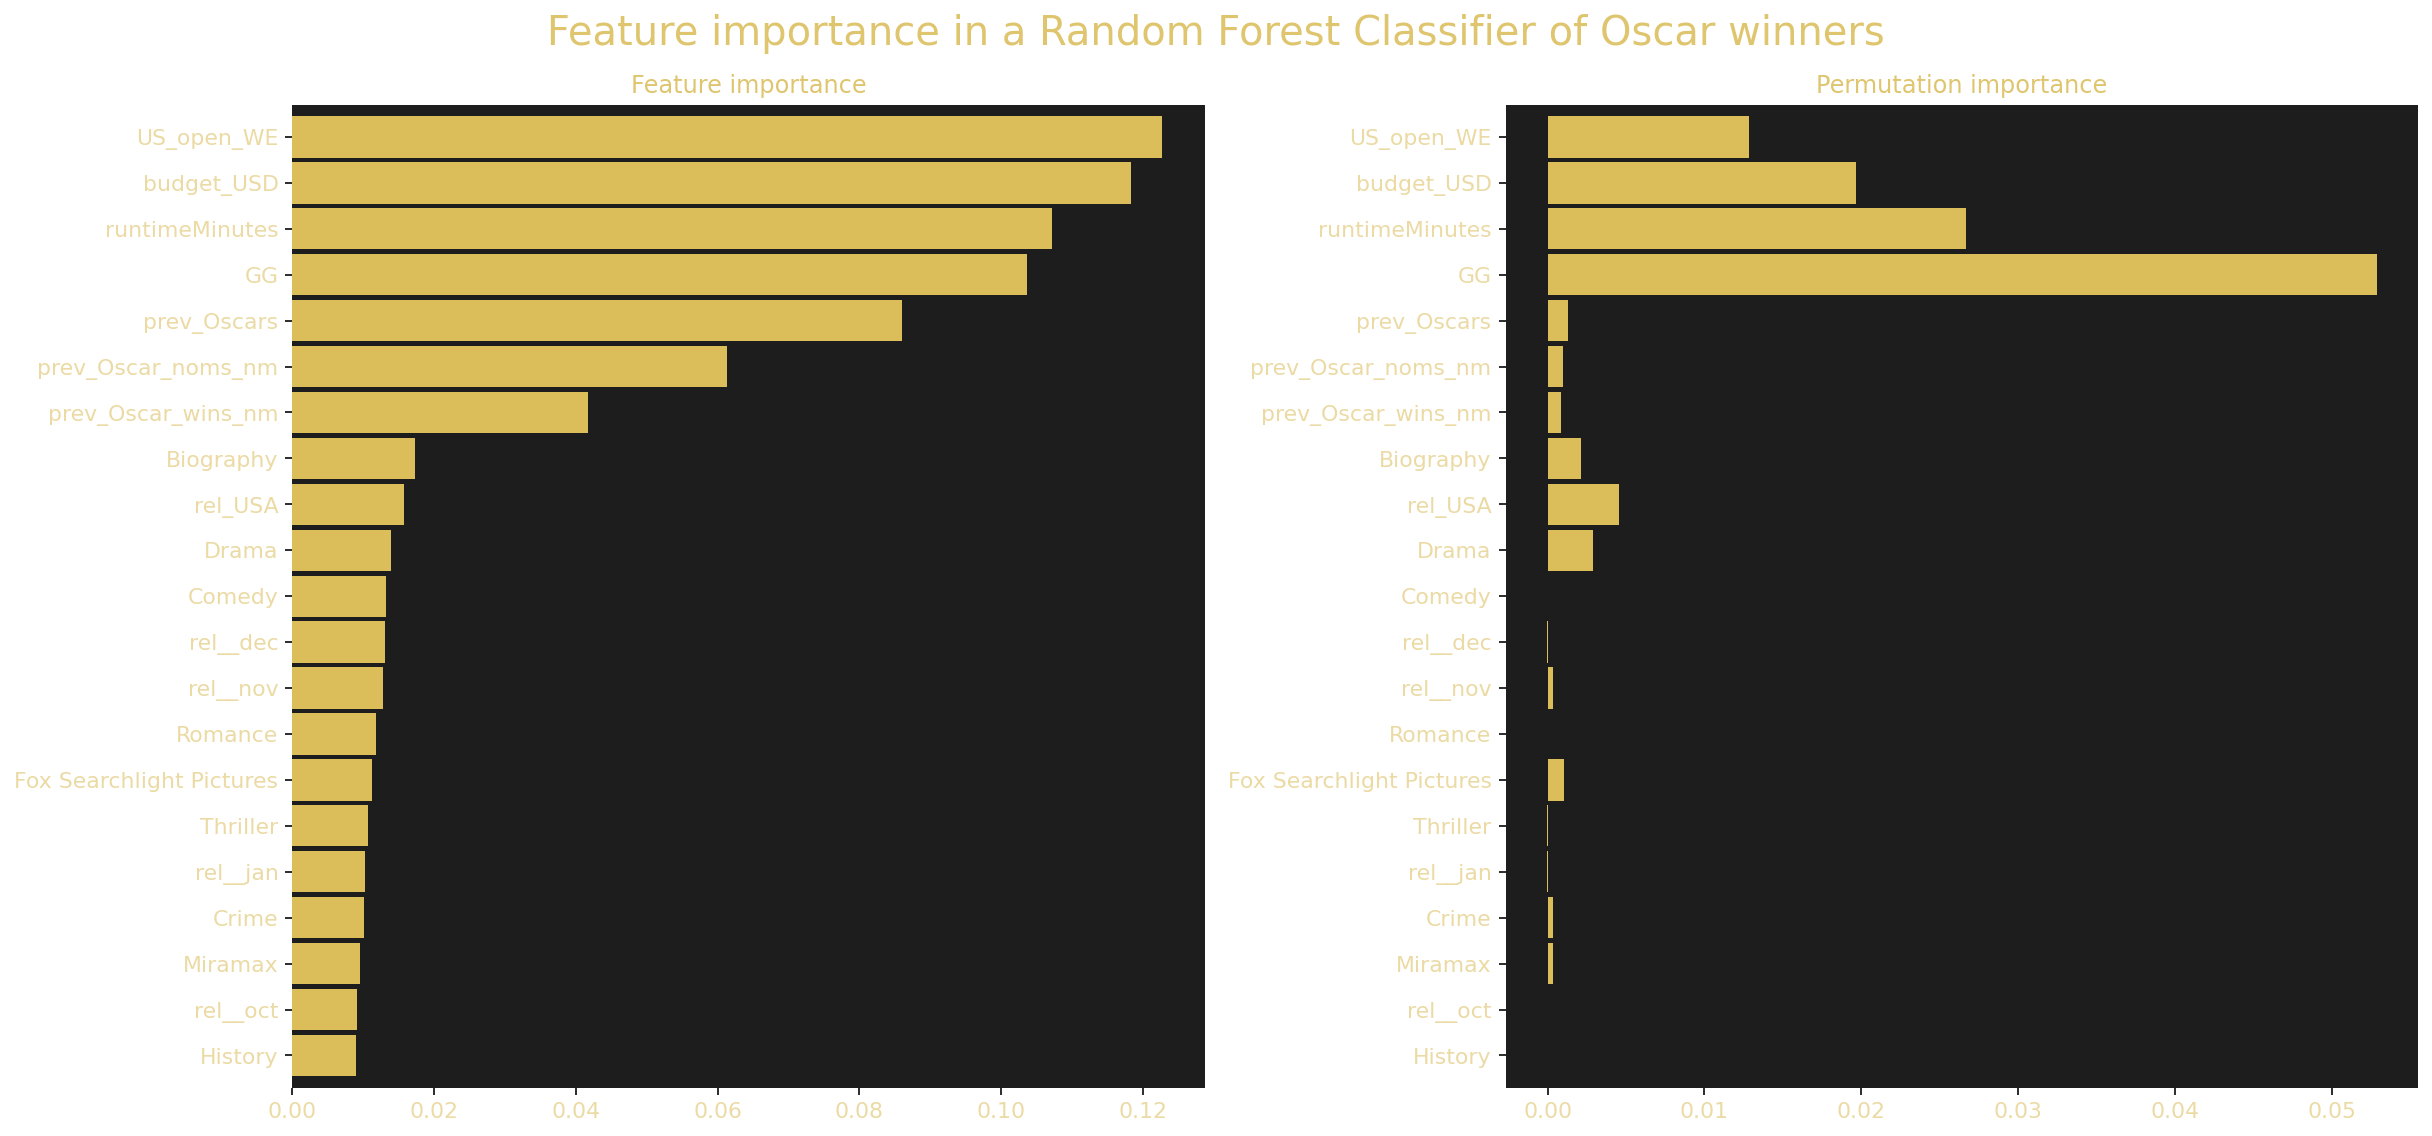

In [38]:
plt.figure(figsize=(17,8));
plt.rcParams['text.color'] = '#dfc56e'
plt.suptitle('Feature importance in a Random Forest Classifier of Oscar winners',fontsize =20);
plt.subplot(1,2,1);
fig1 = rfc_win_features[20::-1]['feature_importance'].plot(kind= 'barh', cmap = golds, title = '\n\nFeature importance', width = 0.9)
fig1.patch.set_facecolor('#1d1d1d')
plt.yticks(fontsize=11, color='#ebdaa4')
plt.xticks(fontsize=11, color='#ebdaa4')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.tight_layout();

plt.subplot(1,2,2);
fig2 = rfc_win_features[20::-1]['permutation_imp'].plot(kind= 'barh', cmap = golds, title = 'Permutation importance', width = 0.9);
fig2.patch.set_facecolor('#1d1d1d')
plt.yticks(fontsize=11, color='#ebdaa4')
plt.xticks(fontsize=11, color='#ebdaa4')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.tight_layout();

plt.savefig('../visualizations/feat_imp_rfc_win.png',facecolor=fig.get_facecolor(), edgecolor='none')

#### 2.4.3 Investigating false positives and false negatives

In [39]:
test_preds = pd.DataFrame(index = X_test.index, columns = ['RFC_win', 'RFC_win_proba'], 
                         data = np.array([rfc_win.predict(Z_test), [_[1] for _ in rfc_win.predict_proba(Z_test)]]).T)

true_win = {tconst: tw for tconst, tw in zip(movies.index, movies['Oscar_winner'])}
title = {tconst: title for tconst, title in zip(movies.index, movies['primaryTitle'])}

test_preds.sort_values('RFC_win_proba', inplace= True, ascending=False)
test_preds['true_win'] = test_preds.index.map(true_win)
test_preds = test_preds.merge(titles[['primaryTitle', 'genres', 'runtimeMinutes', 'startYear']], how = 'left', left_index = True, right_index = True)

##### False positives

In [40]:
fp = test_preds[(test_preds['true_win']==0) & (test_preds['RFC_win']==1)].sort_values(['RFC_win_proba'], ascending = False).head(10)
fp.drop_duplicates(inplace = True)
fp.sort_values(['RFC_win_proba'], ascending = False).head(10)

,RFC_win,RFC_win_proba,true_win,primaryTitle,genres,runtimeMinutes,startYear
tconst,,,,,,,
tt1216475,1.0,0.51,0,Cars 2,"Adventure,Animation,Comedy",106,2011.0


##### False negatives

In [41]:
fn = test_preds[(test_preds['true_win']==1) & (test_preds['RFC_win']==0)].sort_values(['RFC_win_proba'], ascending = True).head(10)
fn.drop_duplicates(inplace = True)
fn.sort_values(['RFC_win_proba'], ascending = True).head(10)

,RFC_win,RFC_win_proba,true_win,primaryTitle,genres,runtimeMinutes,startYear
tconst,,,,,,,


***
## PART 3: Predicting which movie might **get nominated** for Best Picture

### 3.1. Baseline model

In [42]:
movies['best_pic'] = movies['picture_NW'].notna().astype(int)

In [43]:
movies['best_pic'].value_counts(normalize= False)

0    175467
1       228
Name: best_pic, dtype: int64

In [44]:
y = movies['best_pic']
bm = BaselineModel(y)
print(f"The naive baseline model has accuracy of {round(bm.score(),4)} and recall of {round(recall_score(y, bm.predict()),4)}.")

The naive baseline model has accuracy of 0.9987 and recall of 0.0.


### 3.2. Logistic regression on bootstrapped data

#### 3.2.1. Predicting best picture contenders using all independent variabless in `X-vars_all`

In [45]:
movies_btstrp['best_pic'] = movies_btstrp['picture_NW'].notna().astype(int)

X = movies_btstrp[X_vars_all]
y = movies_btstrp['best_pic']

X_train, X_test, y_train, y_test = train_test_split(X,y)

stan = StandardScaler()
Z_train = stan.fit_transform(X_train)
Z_test = stan.transform(X_test)

In [46]:
logr_bp = LogisticRegression(max_iter = 10000)
logr_bp.fit(X_train, y_train)

print(f"Logistic regression using five most predictive variables has accuracy of {round(logr_bp.score(X_train, y_train),4)} on train data and {round(logr_bp.score(X_test, y_test),4)} on test data.")
print(f"The same model has a recall score of {round(recall_score(y_train, logr_bp.predict(X_train)),4)} on train data and {round(recall_score(y_test, logr_bp.predict(X_test)),4)} on test data.")

print(f"The model's accuracy calculated in 5-fold cross-validation is {round(cross_val_score(logr_bp, Z_test, y_test).mean(),4)}.")
print(f"The model's recall calculated in 5-fold cross-validation is {round(cross_val_score(logr_bp, Z_test, y_test, scoring='recall').mean(),4)}.")

Logistic regression using five most predictive variables has accuracy of 0.8834 on train data and 0.8823 on test data.
The same model has a recall score of 0.0 on train data and 0.0 on test data.
The model's accuracy calculated in 5-fold cross-validation is 0.9416.
The model's recall calculated in 5-fold cross-validation is 0.4137.


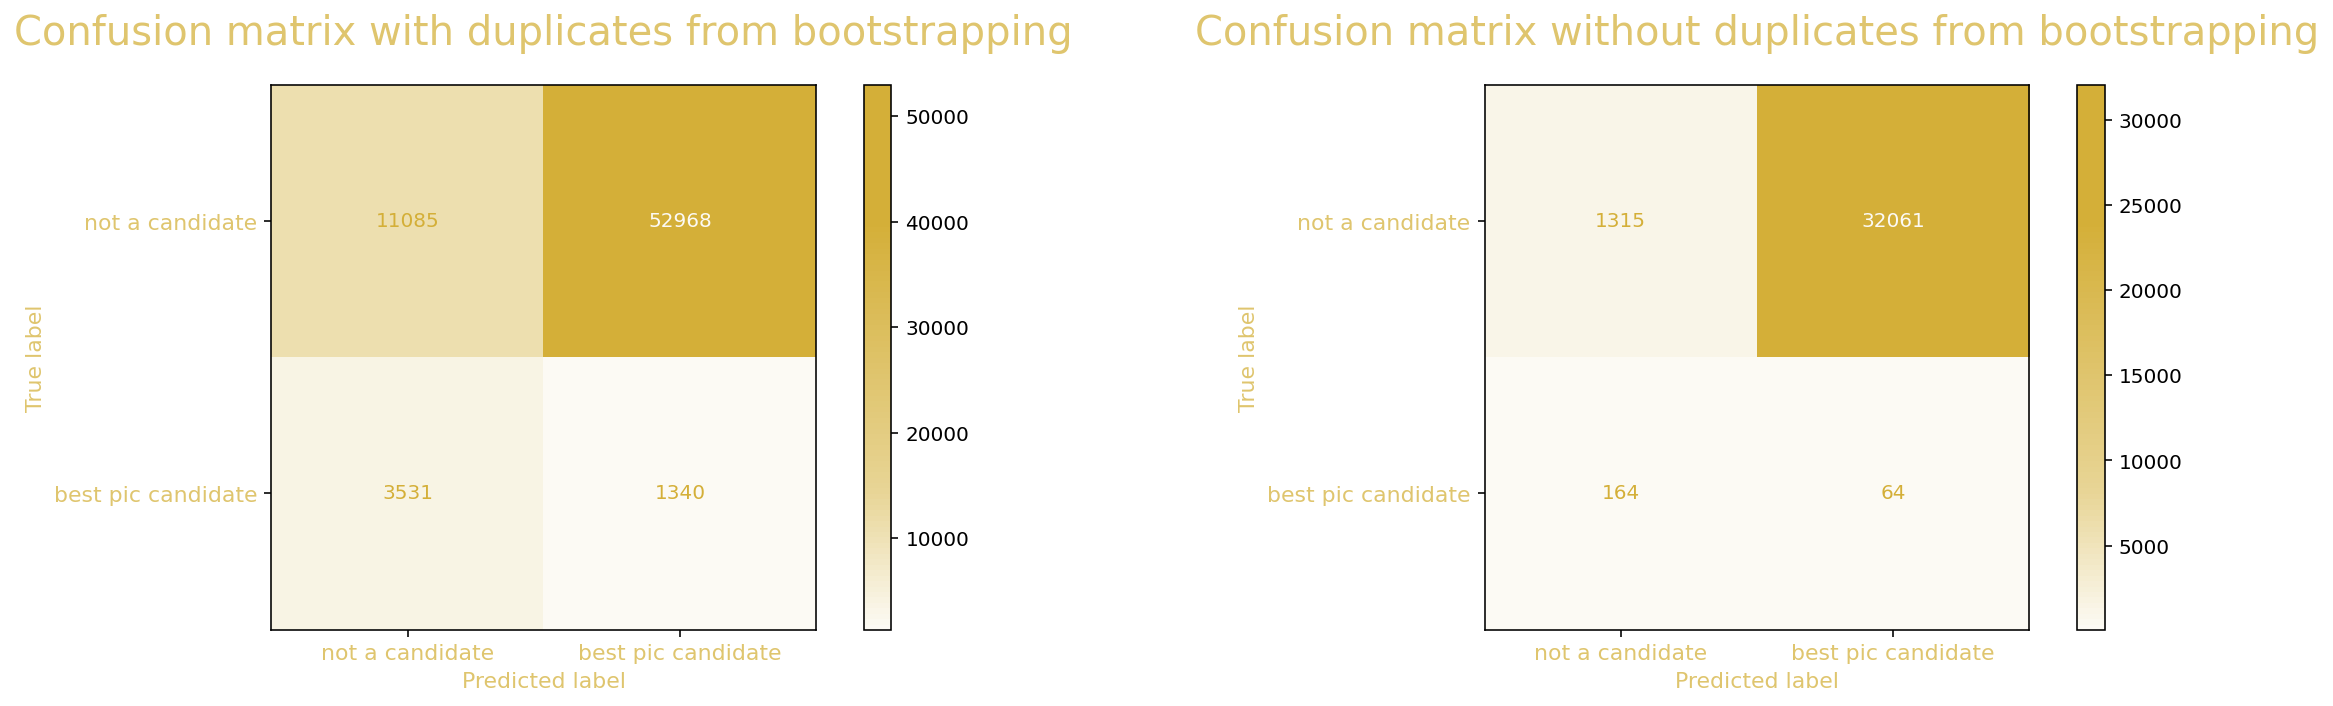

In [47]:
plot_confusion_matrices(logr_bp, Z_test, y_test, cmap = golds_cm, labels = ['not a candidate', 'best pic candidate'], ver = 'logr_bp')

### 3.3. Random Forest Classification on bootstrapped data

#### 3.3.1 Predicting Best Picture contenders using all independent variabless in X-vars_all

In [48]:
X = movies_btstrp[X_vars_all]
y = movies_btstrp['best_pic']

X_train, X_test, y_train, y_test = train_test_split(X,y)

stan = StandardScaler()
Z_train = stan.fit_transform(X_train)
Z_test = stan.transform(X_test)

In [49]:
rfc_bp = RandomForestClassifier()
rfc_bp.fit(Z_train, y_train)

print(f"The Random Forest Classifier has an accuracy of {round(rfc_bp.score(Z_train, y_train),4)} on train data and {round(rfc_bp.score(Z_test, y_test),4)} on test data.")
print(f"The same model has a recall score of {round(recall_score(y_train, rfc_bp.predict(Z_train)),4)} on train data and {round(recall_score(y_test, rfc_bp.predict(Z_test)),4)} on test data.")

print(f"The model's accuracy calculated in 5-fold cross-validation is {round(cross_val_score(rfc_bp, Z_test, y_test).mean(),4)}.")
print(f"The model's recall calculated in 5-fold cross-validation is {round(cross_val_score(rfc_bp, Z_test, y_test, scoring='recall').mean(),4)}.")

The Random Forest Classifier has an accuracy of 0.9997 on train data and 0.9996 on test data.
The same model has a recall score of 1.0 on train data and 1.0 on test data.
The model's accuracy calculated in 5-fold cross-validation is 0.9996.
The model's recall calculated in 5-fold cross-validation is 0.9959.


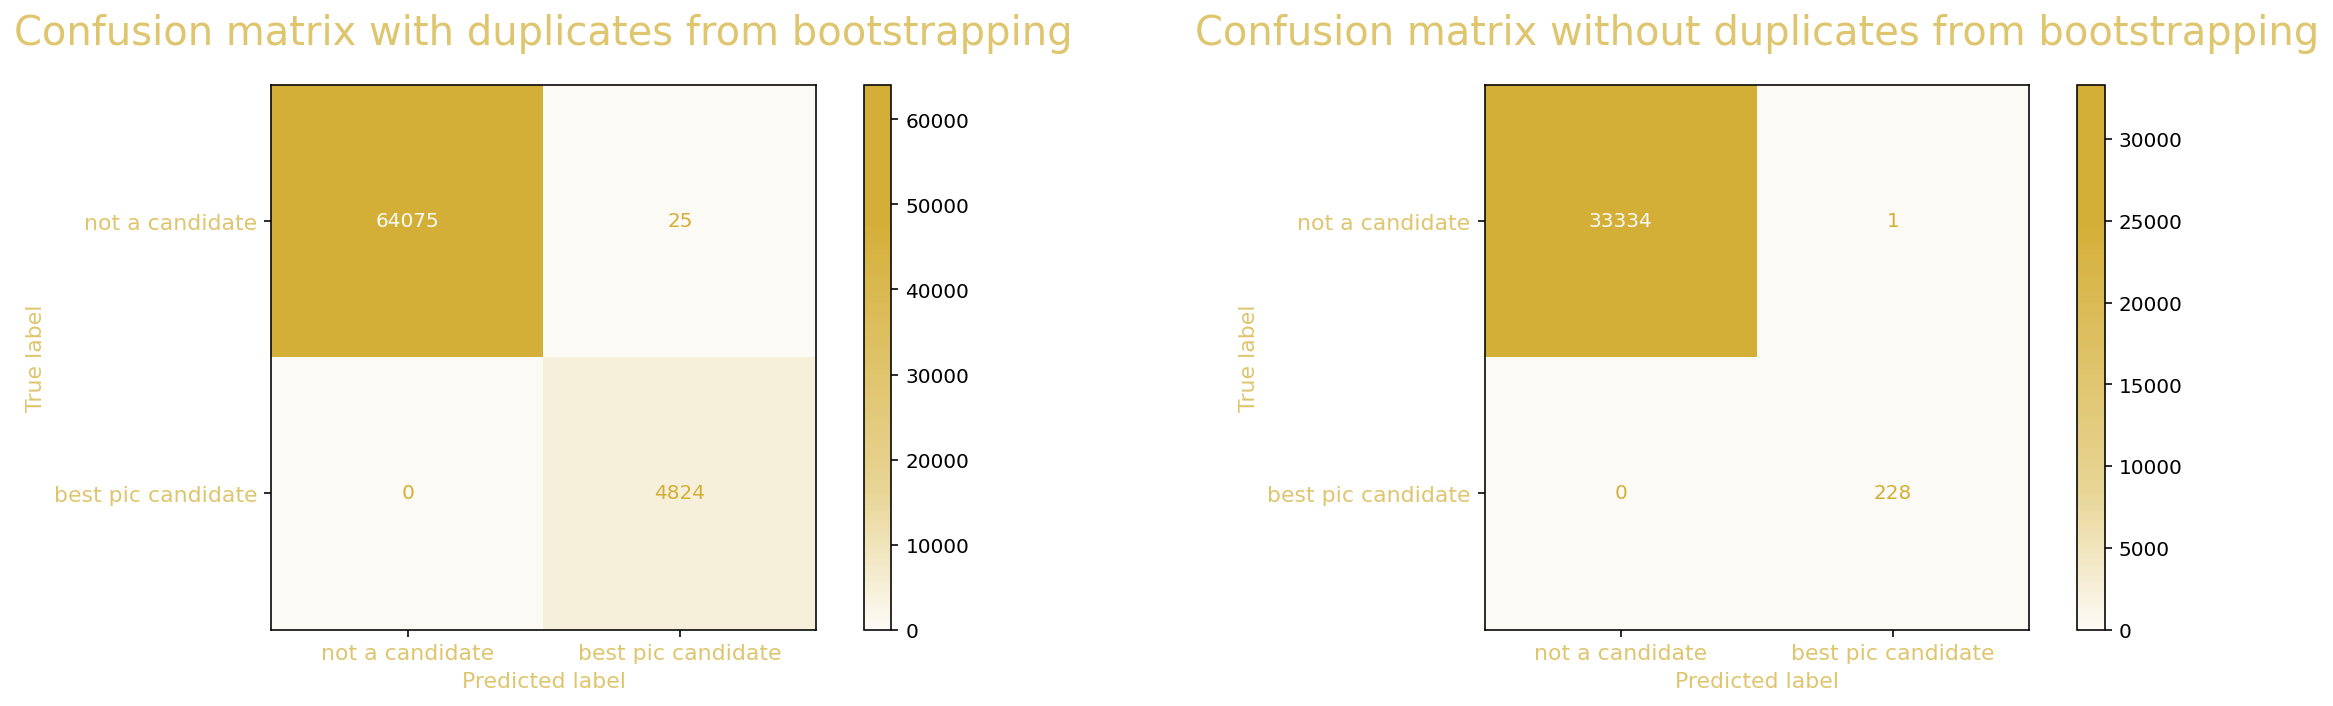

In [50]:
plot_confusion_matrices(rfc_bp, Z_test, y_test, cmap = golds_cm, labels = ['not a candidate','best pic candidate'], ver = 'rfc_bp')

#### 3.3.2 Viewing and interpreting coefficients for most predictive variables

In [51]:
perm_imp = permutation_importance(rfc_bp, Z_test, y_test)['importances_mean']

perm_imp_df = pd.DataFrame(perm_imp, index =X.columns, columns = ['permutation_imp'])

rfc_bp_features = pd.DataFrame(index = X.columns, data = rfc_bp.feature_importances_, columns=['feature_importance'])
rfc_bp_features.sort_values(['feature_importance'], ascending = False, inplace = True)
rfc_bp_features = rfc_bp_features.merge(perm_imp_df, left_index = True, right_index = True)

rfc_bp_features[:10]

,feature_importance,permutation_imp
budget_USD,0.118278,0.020866
US_open_WE,0.111417,0.007025
runtimeMinutes,0.106117,0.026493
prev_Oscars,0.100252,0.005685
prev_Oscar_noms_nm,0.086837,0.006349
GG,0.085540,0.049539
prev_Oscar_wins_nm,0.046154,0.001451
Drama,0.016484,0.002217
rel__dec,0.016160,0.001108
rel_USA,0.014812,0.000546


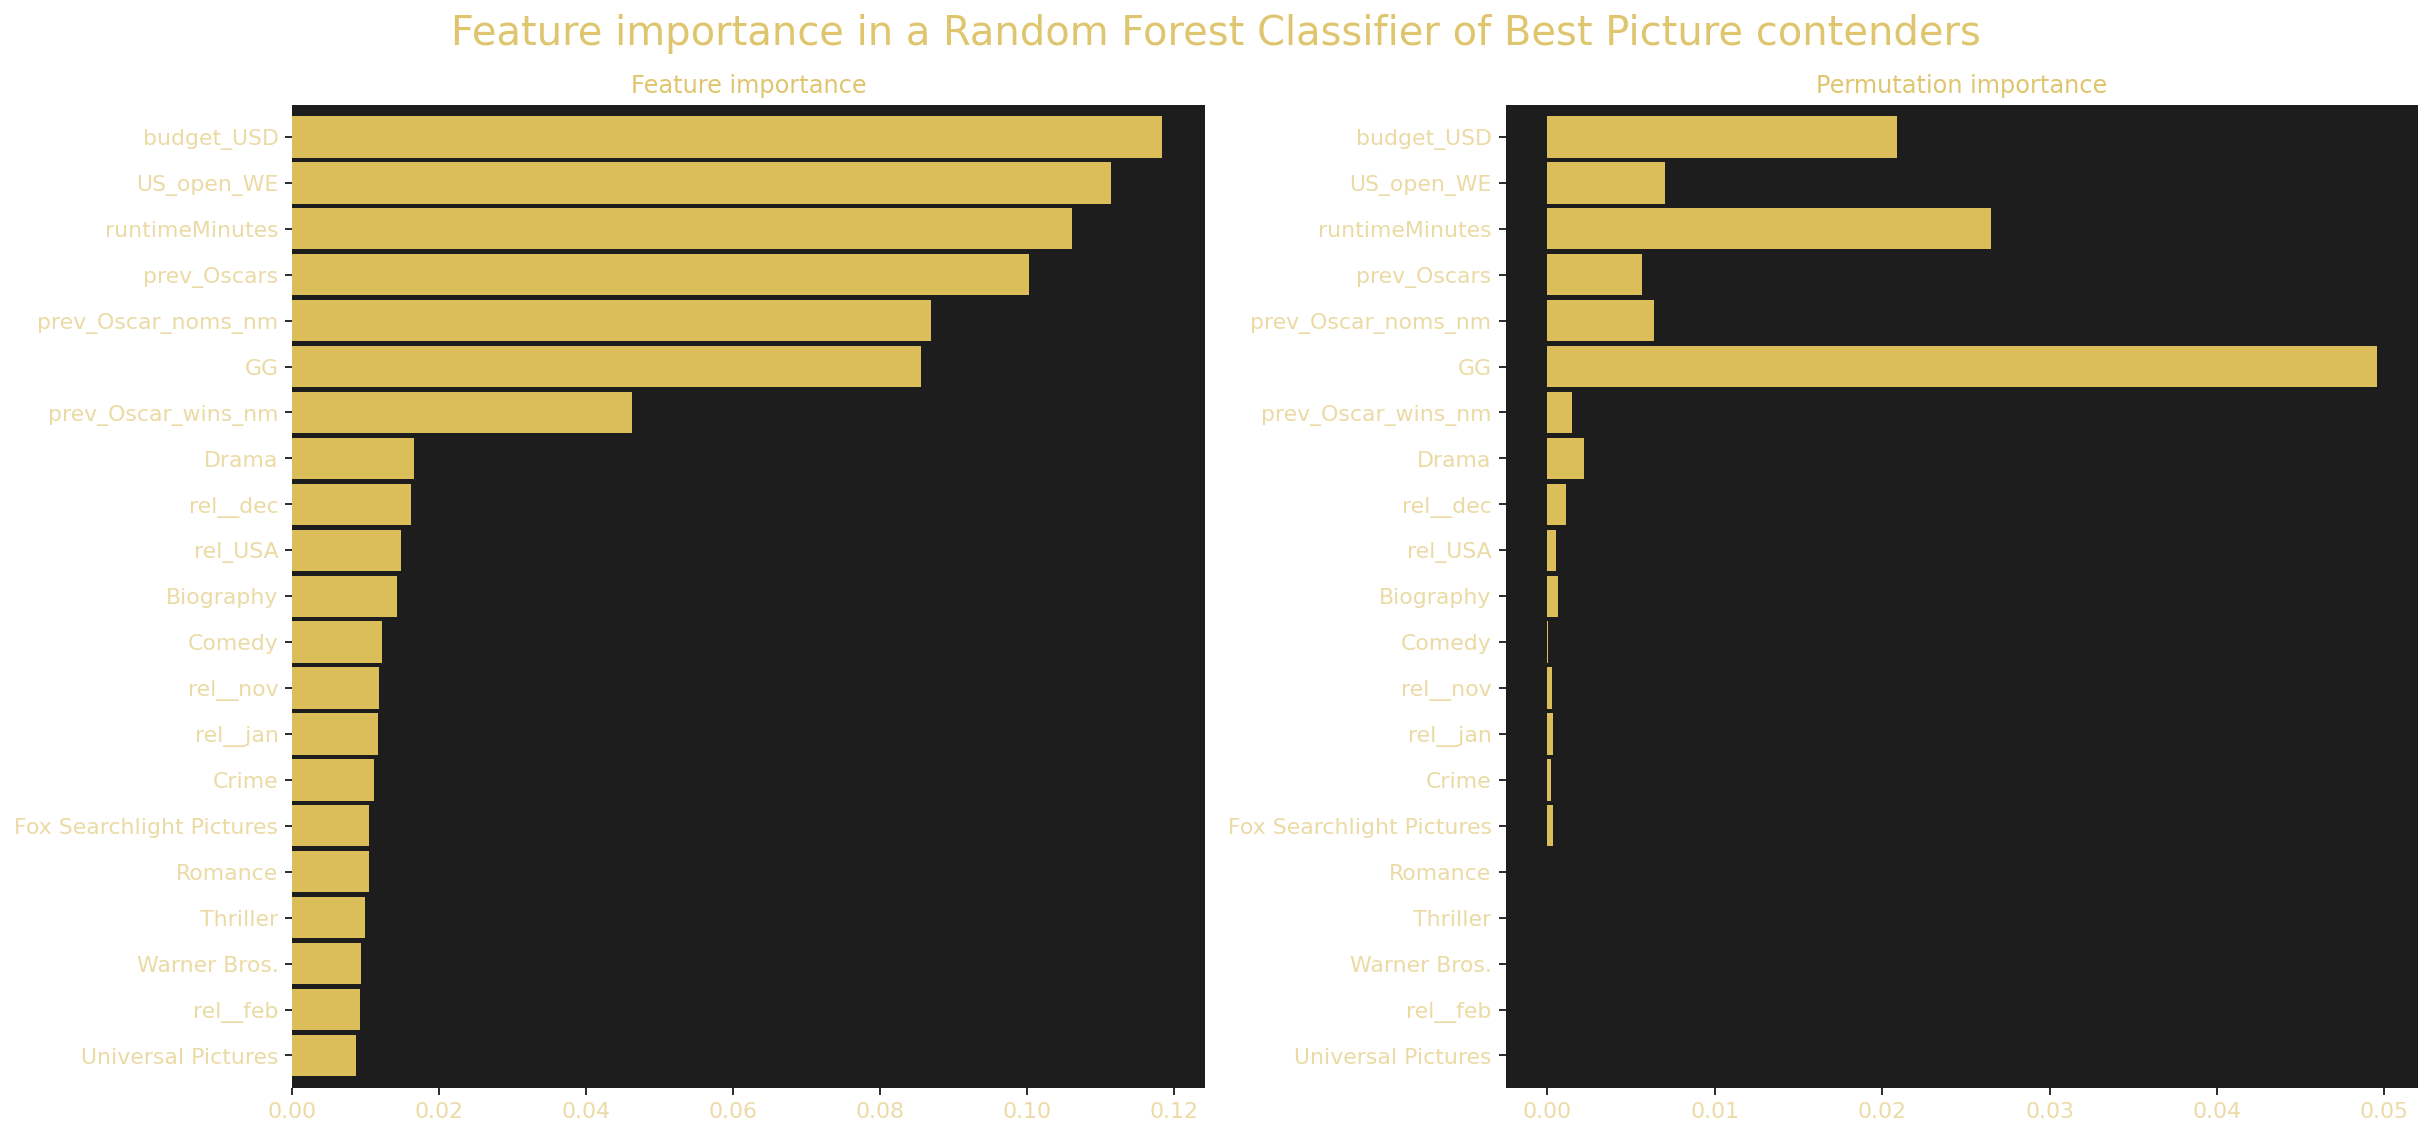

In [52]:
plt.figure(figsize=(17,8));
plt.suptitle('Feature importance in a Random Forest Classifier of Best Picture contenders', fontsize = 20);
plt.subplot(1,2,1);
fig1 = rfc_bp_features[20::-1]['feature_importance'].plot(kind= 'barh', cmap = golds, title = '\n\nFeature importance', width = 0.9);
fig1.patch.set_facecolor('#1d1d1d')
plt.yticks(fontsize=11, color='#ebdaa4')
plt.xticks(fontsize=11, color='#ebdaa4')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

plt.subplot(1,2,2);
fig2 = rfc_bp_features[20::-1]['permutation_imp'].plot(kind= 'barh', cmap = golds, title = 'Permutation importance', width = 0.9);
plt.yticks(fontsize=11, color='#ebdaa4')
plt.xticks(fontsize=11, color='#ebdaa4')
fig2.patch.set_facecolor('#1d1d1d')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.tight_layout();

plt.savefig('../visualizations/feat_imp_rfc_bp.png',facecolor=fig.get_facecolor(), edgecolor='none')

#### 3.3.3 Investigating false positives and false negatives

In [53]:
test_preds = pd.DataFrame(index = X_test.index, columns = ['RFC_bp_nom', 'RFC_bp_nom_proba'], 
                         data = np.array([rfc_bp.predict(Z_test), [_[1] for _ in rfc_bp.predict_proba(Z_test)]]).T)

true_bp = {tconst: tbp for tconst, tbp in zip(movies.index, movies['best_pic'])}
title = {tconst: title for tconst, title in zip(movies.index, movies['primaryTitle'])}

test_preds.sort_values('RFC_bp_nom_proba', inplace= True, ascending=False)
test_preds['true_bp_nom'] = test_preds.index.map(true_bp)
test_preds = test_preds.merge(titles[['primaryTitle', 'genres', 'runtimeMinutes', 'startYear']], how = 'left', left_index = True, right_index = True)

##### False positives

In [54]:
fp = test_preds[(test_preds['true_bp_nom']==0) & (test_preds['RFC_bp_nom']==1)].sort_values(['RFC_bp_nom_proba'], ascending = False).head(10)
fp.drop_duplicates(inplace = True)
fp.sort_values(['RFC_bp_nom_proba'], ascending = False).head(10)

,RFC_bp_nom,RFC_bp_nom_proba,true_bp_nom,primaryTitle,genres,runtimeMinutes,startYear
tconst,,,,,,,


##### False negatives

In [55]:
fn = test_preds[(test_preds['true_bp_nom']==1) & (test_preds['RFC_bp_nom']==0)].sort_values(['RFC_bp_nom_proba'], ascending = True).head(10)
fn.drop_duplicates(inplace = True)
fn.sort_values(['RFC_bp_nom_proba'], ascending = True).head(10)

,RFC_bp_nom,RFC_bp_nom_proba,true_bp_nom,primaryTitle,genres,runtimeMinutes,startYear
tconst,,,,,,,


In [56]:
pickle.dump(rfc_bp, open('../pickles/rfc_bp.p', 'bw'))

***
## PART 4: Predicting which movies have the highest chances of **winning** Best Picture

### 4.1. Baseline model

In [57]:
movies['best_pic_win'] = (movies['picture_NW']=='W').astype(int)

In [58]:
movies['best_pic_win'].value_counts(normalize= False)

0    175665
1        30
Name: best_pic_win, dtype: int64

In [59]:
y = movies['best_pic_win']
bm = BaselineModel(y)
print(f"The naive baseline model has accuracy of {round(bm.score(),4)} and recall of {round(recall_score(y, bm.predict()),4)}.")

The naive baseline model has accuracy of 0.9998 and recall of 0.0.


### 4.2. Logistic regression on bootstrapped data

#### 4.2.1. Predicting best picture winners using all independent variabless in `X-vars_all`

In [60]:
movies_btstrp['best_pic_win'] = (movies_btstrp['picture_NW']=='W').astype(int)

X = movies_btstrp[X_vars_all]
y = movies_btstrp['best_pic_win']

X_train, X_test, y_train, y_test = train_test_split(X,y)

stan = StandardScaler()
Z_train = stan.fit_transform(X_train)
Z_test = stan.transform(X_test)

In [61]:
logr_bp_win = LogisticRegression()
logr_bp_win.fit(X_train, y_train)

print(f"Logistic regression using five most predictive variables has accuracy of {round(logr_bp_win.score(X_train, y_train),4)} on train data and {round(logr_bp_win.score(X_test, y_test),4)} on test data.")
print(f"The same model has a recall score of {round(recall_score(y_train, logr_bp_win.predict(X_train)),4)} on train data and {round(recall_score(y_test, logr_bp_win.predict(X_test)),4)} on test data.")

print(f"The model's accuracy calculated in 5-fold cross-validation is {round(cross_val_score(logr_bp_win, Z_test, y_test).mean(),4)}.")
print(f"The model's recall calculated in 5-fold cross-validation is {round(cross_val_score(logr_bp_win, Z_test, y_test, scoring='recall').mean(),4)}.")

Logistic regression using five most predictive variables has accuracy of 0.9911 on train data and 0.991 on test data.
The same model has a recall score of 0.0 on train data and 0.0 on test data.


/Users/martalew/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/martalew/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

The model's accuracy calculated in 5-fold cross-validation is 0.9911.


/Users/martalew/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/martalew/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

The model's recall calculated in 5-fold cross-validation is 0.0578.


/Users/martalew/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


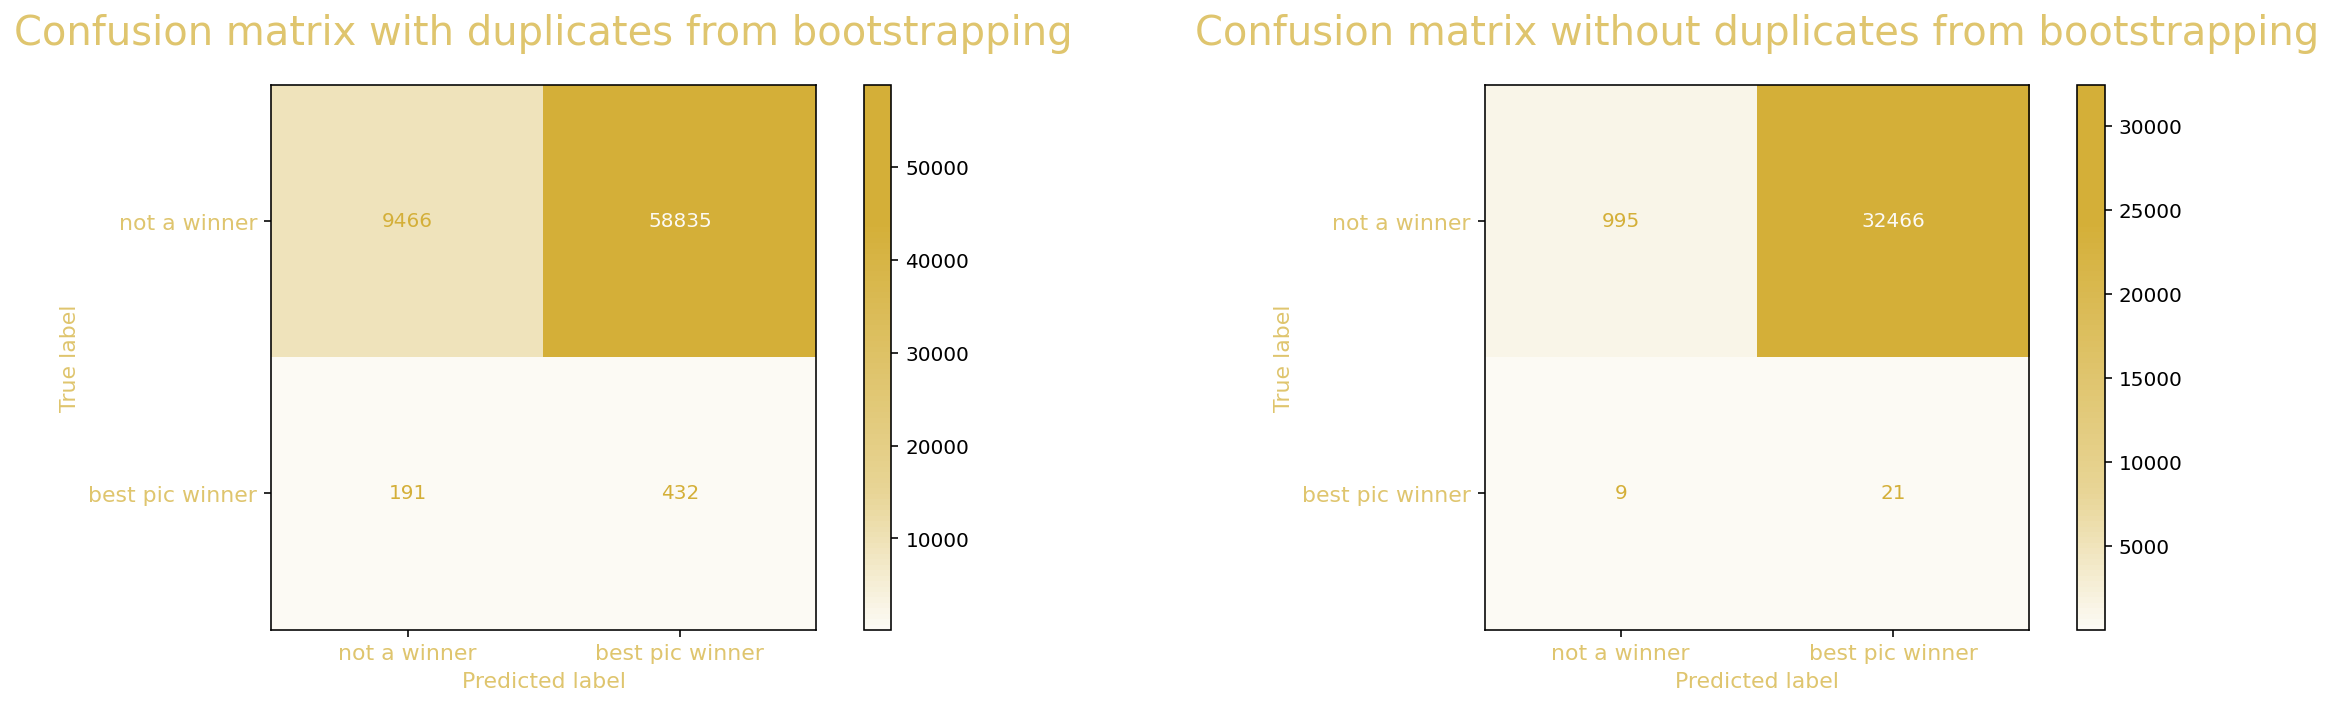

In [62]:
plot_confusion_matrices(logr_bp_win, Z_test, y_test, cmap = golds_cm, labels = ['not a winner', 'best pic winner'], ver = 'logr_bp_win');

### 4.3. Random Forest Classification on bootstrapped data

#### 4.3.1 Predicting Best Picture winners using all independent variabless in X-vars_all

In [63]:
movies_btstrp['best_pic_win'] = (movies_btstrp['picture_NW']=='W').astype(int)

X = movies_btstrp[X_vars_all]
y = movies_btstrp['best_pic_win']

X_train, X_test, y_train, y_test = train_test_split(X,y)

stan = StandardScaler()
Z_train = stan.fit_transform(X_train)
Z_test = stan.transform(X_test)

In [64]:
rfc_bp_win = RandomForestClassifier()
rfc_bp_win.fit(Z_train, y_train)

print(f"The Random Forest Classifier has an accuracy of {round(rfc_bp_win.score(Z_train, y_train),4)} on train data and {round(rfc_bp_win.score(Z_test, y_test),4)} on test data.")
print(f"The same model has a recall score of {round(recall_score(y_train, rfc_bp_win.predict(Z_train)),4)} on train data and {round(recall_score(y_test, rfc_bp_win.predict(Z_test)),4)} on test data.")

print(f"The model's accuracy calculated in 5-fold cross-validation is {round(cross_val_score(rfc_bp_win, Z_test, y_test).mean(),4)}.")
print(f"The model's recall calculated in 5-fold cross-validation is {round(cross_val_score(rfc_bp_win, Z_test, y_test, scoring='recall').mean(),4)}.")

The Random Forest Classifier has an accuracy of 0.9997 on train data and 0.9997 on test data.
The same model has a recall score of 1.0 on train data and 1.0 on test data.
The model's accuracy calculated in 5-fold cross-validation is 0.9996.
The model's recall calculated in 5-fold cross-validation is 0.9836.


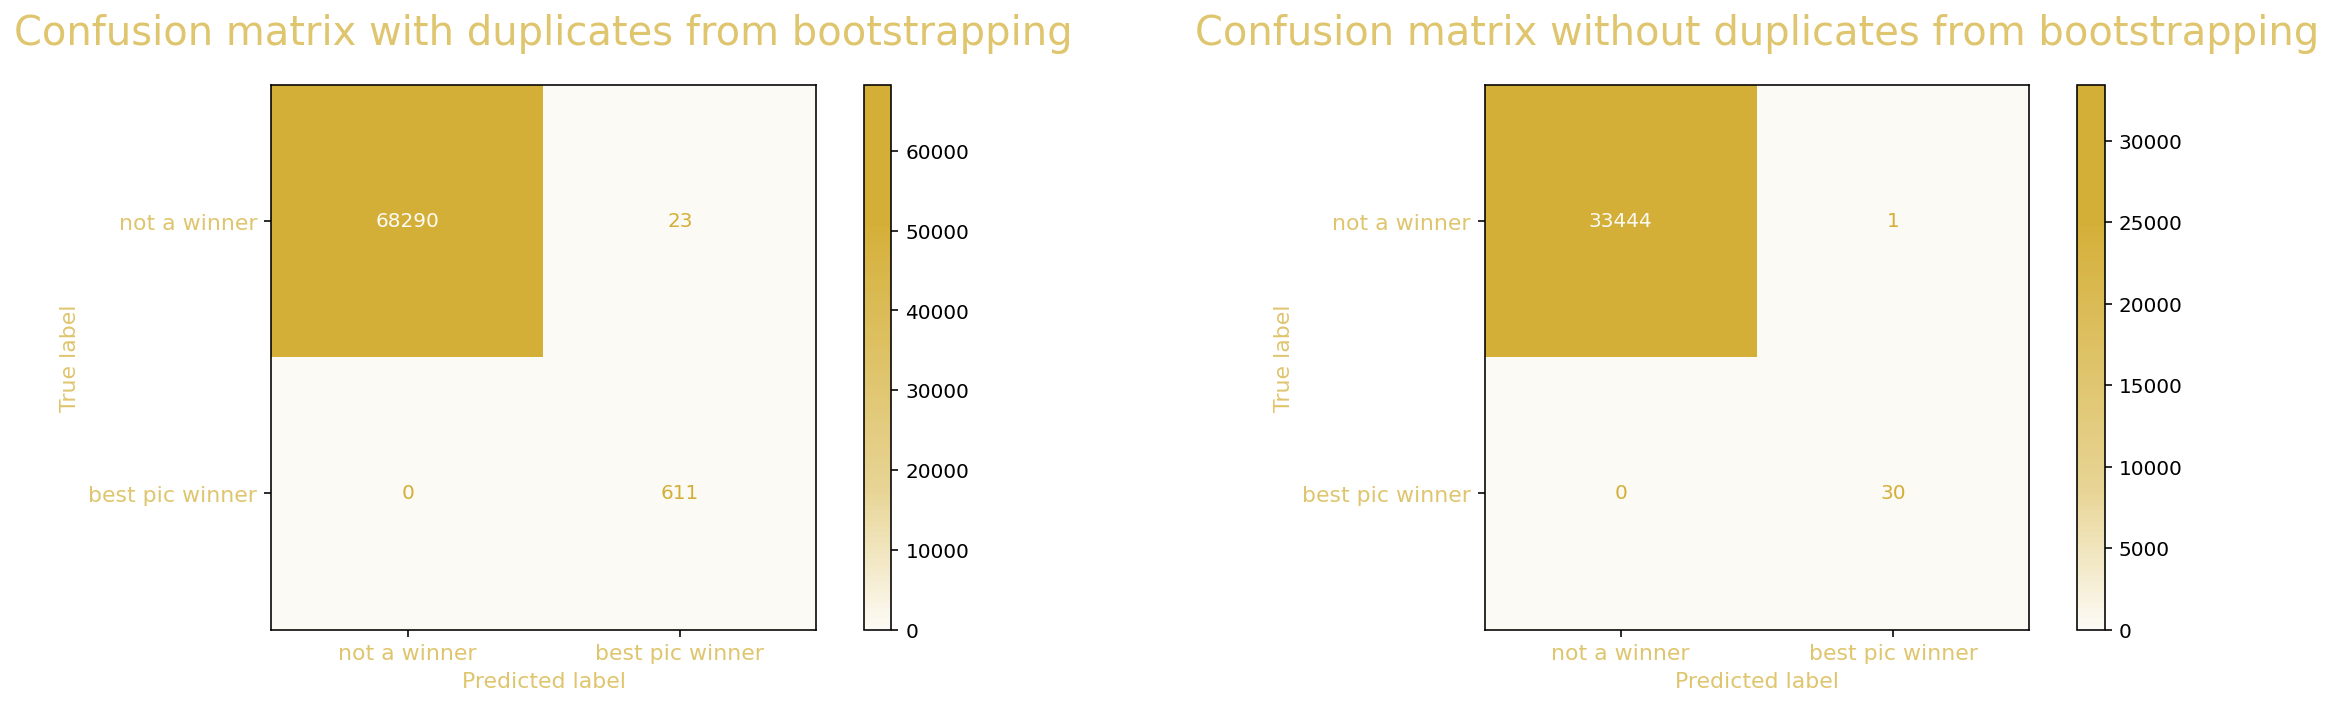

In [65]:
plot_confusion_matrices(rfc_bp_win, Z_test, y_test, cmap = golds_cm, labels = ['not a winner', 'best pic winner'], ver = 'rfc_bp_win');

In [66]:
pickle.dump(rfc_bp_win, open('../pickles/rfc_bp_win.p', 'wb'))

#### 4.3.2 Viewing and interpreting coefficients for most predictive variables

In [67]:
perm_imp = permutation_importance(rfc_bp_win, Z_test, y_test)['importances_mean']

perm_imp_df = pd.DataFrame(perm_imp, index =X.columns, columns = ['permutation_imp'])

rfc_bp_win_features = pd.DataFrame(index = X.columns, data = rfc_bp_win.feature_importances_, columns=['feature_importance'])
rfc_bp_win_features.sort_values(['feature_importance'], ascending = False, inplace = True)
rfc_bp_win_features = rfc_bp_win_features.merge(perm_imp_df, left_index = True, right_index = True)

rfc_bp_win_features[:10]

,feature_importance,permutation_imp
runtimeMinutes,0.131629,0.002403
budget_USD,0.119890,0.005049
US_open_WE,0.114661,0.000505
prev_Oscars,0.093118,0.000400
prev_Oscar_noms_nm,0.073744,0.001198
prev_Oscar_wins_nm,0.043930,0.000252
GG,0.023129,0.006210
Thriller,0.022217,0.000177
Dreamworks Pictures,0.021695,0.001172
Biography,0.021410,0.000006


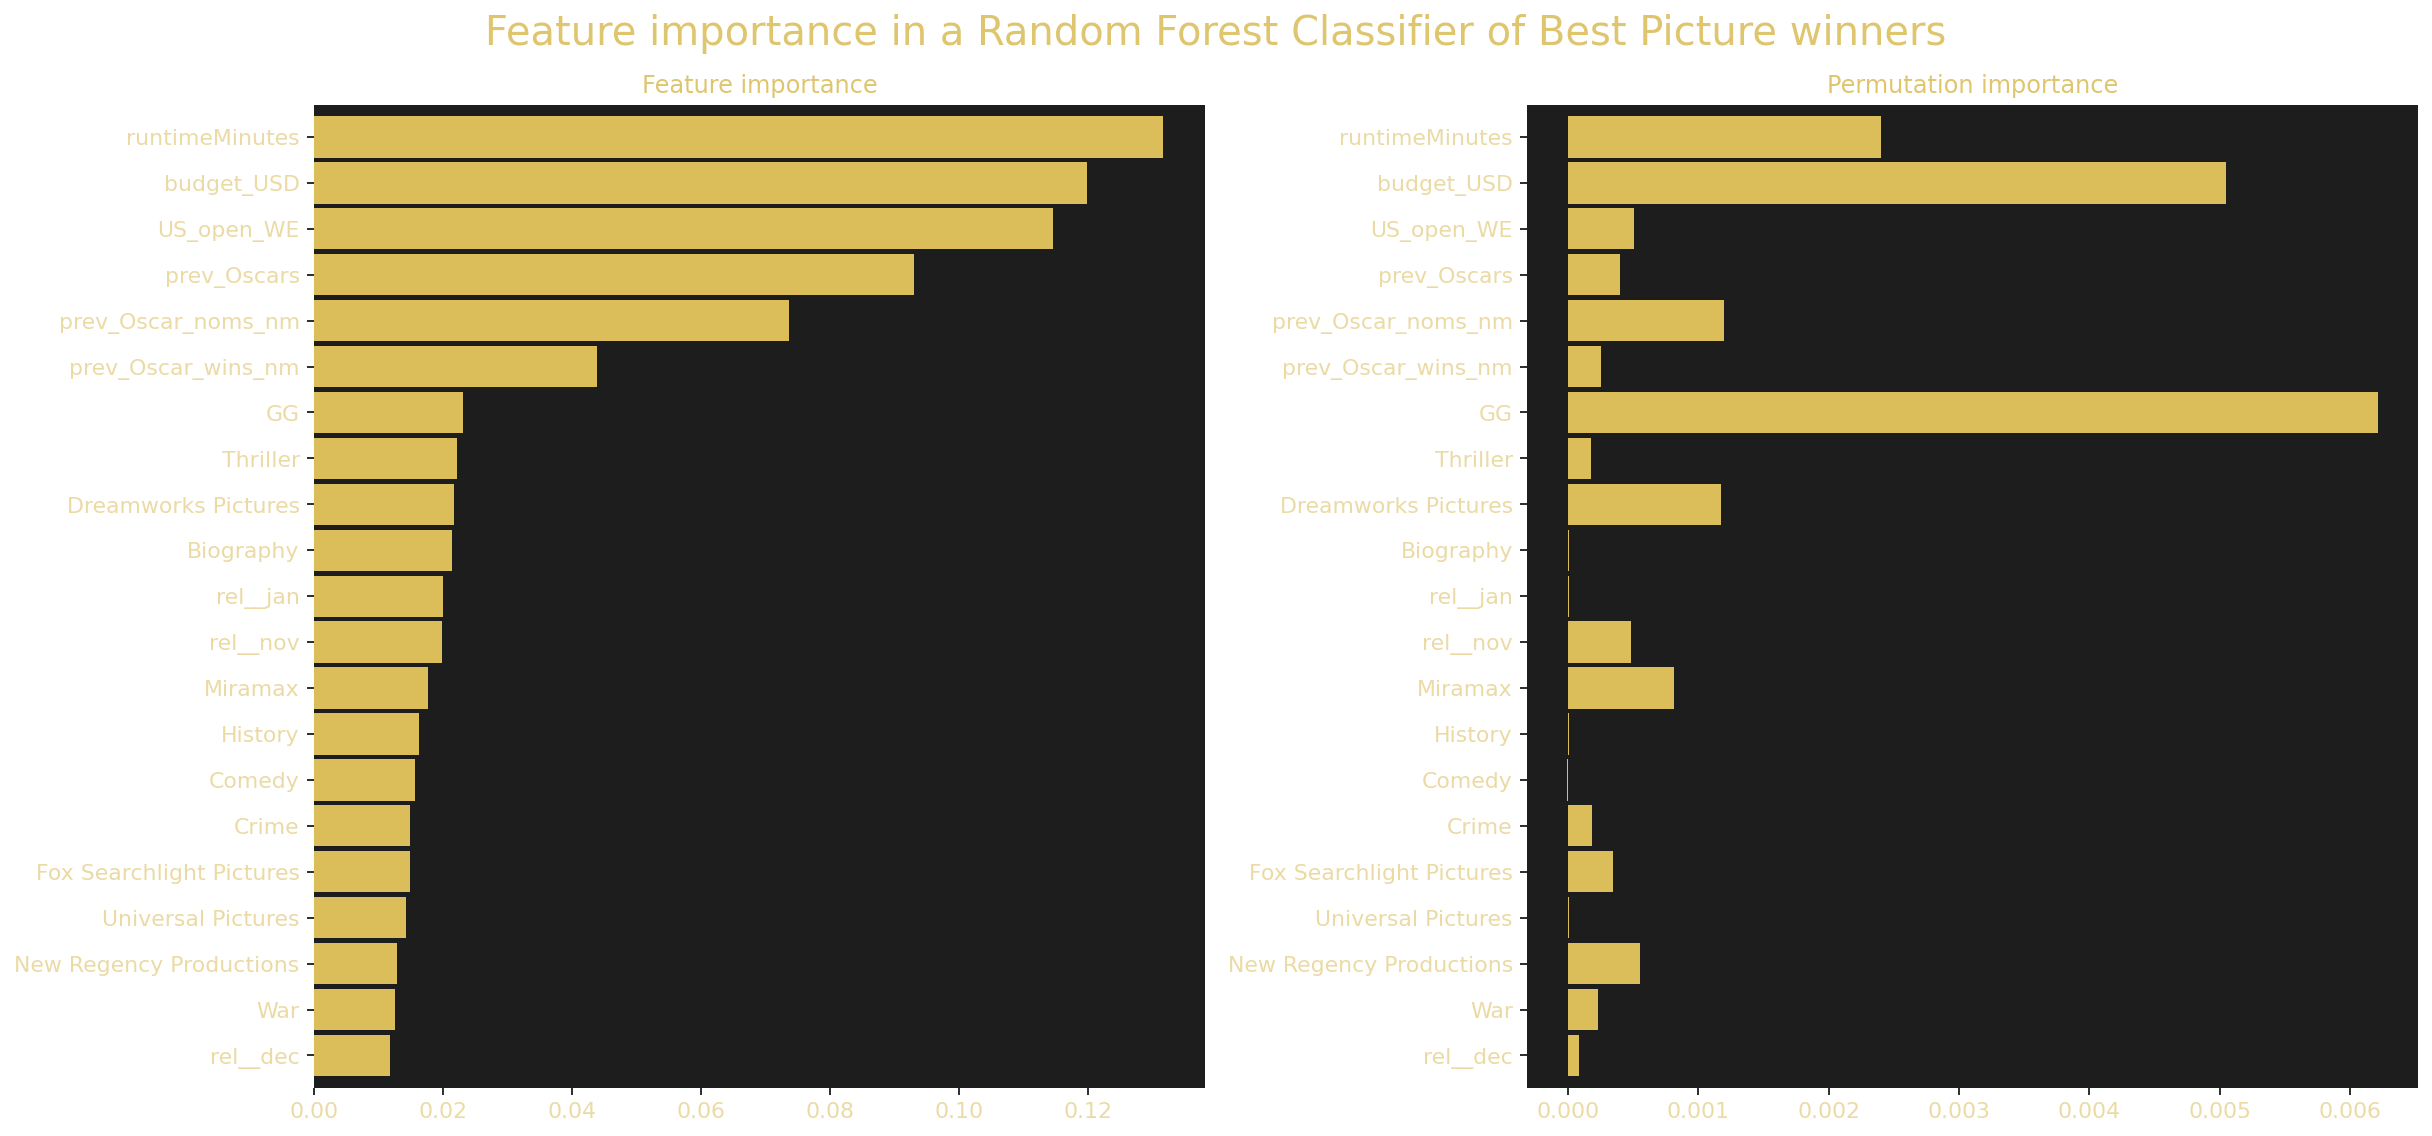

In [68]:
plt.figure(figsize=(17,8));
plt.suptitle('Feature importance in a Random Forest Classifier of Best Picture winners', fontsize = 20);
plt.subplot(1,2,1);
fig1 = rfc_bp_win_features[20::-1]['feature_importance'].plot(kind= 'barh', cmap = golds, title = '\n\nFeature importance', width = 0.9);
fig1.patch.set_color('#1d1d1d')
plt.yticks(fontsize=11, color='#ebdaa4')
plt.xticks(fontsize=11, color='#ebdaa4')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

plt.subplot(1,2,2);
fig2 = rfc_bp_win_features[20::-1]['permutation_imp'].plot(kind= 'barh', cmap = golds, title = 'Permutation importance', width = 0.9);
fig2.patch.set_color('#1d1d1d')
plt.yticks(fontsize=11, color='#ebdaa4')
plt.xticks(fontsize=11, color='#ebdaa4')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.tight_layout();

plt.savefig('../visualizations/feat_imp_rfc_bp_win.png',facecolor=fig.get_facecolor(), edgecolor='none')

#### 4.3.3 Investigating false positives and false negatives

In [69]:
test_preds = pd.DataFrame(index = X_test.index, columns = ['rfc_bp_win', 'RFC_bp_win_proba'], 
                         data = np.array([rfc_bp_win.predict(Z_test), [_[1] for _ in rfc_bp_win.predict_proba(Z_test)]]).T)

true_bpw = {tconst: bpw for tconst, bpw in zip(movies.index, movies['best_pic_win'])}
title = {tconst: title for tconst, title in zip(movies.index, movies['primaryTitle'])}

test_preds.sort_values('RFC_bp_win_proba', inplace= True, ascending=False)
test_preds['true_bp_win'] = test_preds.index.map(true_bpw)
test_preds = test_preds.merge(titles[['primaryTitle', 'genres', 'runtimeMinutes', 'startYear']], how = 'left', left_index = True, right_index = True)
test_preds = test_preds.merge(movies[['oscars_year']], how = 'left', left_index = True, right_index = True)

##### False positives

In [70]:
fp = test_preds[(test_preds['true_bp_win']==0) & (test_preds['rfc_bp_win']==1)].sort_values(['RFC_bp_win_proba'], ascending = False).head(10)
fp.drop_duplicates(inplace = True)
fp.sort_values(['RFC_bp_win_proba'], ascending = False).head(10)

,rfc_bp_win,RFC_bp_win_proba,true_bp_win,primaryTitle,genres,runtimeMinutes,startYear,oscars_year
tconst,,,,,,,,


##### False negatives

In [71]:
fn = test_preds[(test_preds['true_bp_win']==1) & (test_preds['rfc_bp_win']==0)].sort_values(['RFC_bp_win_proba'], ascending = True).head(10)
fn.drop_duplicates(inplace = True)
fn.sort_values(['RFC_bp_win_proba'], ascending = True).head(10)

,rfc_bp_win,RFC_bp_win_proba,true_bp_win,primaryTitle,genres,runtimeMinutes,startYear,oscars_year
tconst,,,,,,,,


***